In [1]:
import torch
import torch.nn as nn
from dataclasses import dataclass
import torchvision
from torchvision import transforms
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter  
from torchvision.utils import save_image

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = 'cpu'
device

'cuda'

In [3]:
@dataclass
class ModelArgs:
    device = 'cuda'
    batch_size = 1
    lr = 0.0002
    img_size = 128
    no_of_channels = 3
    kernel_size = (4,4)
    stride = 2
    # dropout = 0.5
    padding = 1
    lr_slope = 0.2
    beta_1 = 0.5
    beta_2 = 0.999
    no_of_kernel = 64
    lambda_gen = 10

In [4]:
ModelArgs.device = device

In [5]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)  #mean = 0, std = 0.02
        
    if classname.find('Conv2D') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)  #mean = 0, std = 0.02

In [6]:
class ResnetBlock(nn.Module):
    def __init__(self):
        super().__init__()
        
        
        self.main = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=1, padding_mode='reflect', device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
        )
    def forward(self, x):
        
        res = x + self.main(x)
        return res

In [7]:

class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.resnet_blocks = ResnetBlock()
        
        self.down = nn.Sequential(
            
            nn.Conv2d(in_channels=ModelArgs.no_of_channels, out_channels=64, kernel_size=(7,7), stride=1, device=ModelArgs.device, padding=3),
            nn.InstanceNorm2d(num_features=64, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=2, device=ModelArgs.device, padding=1),
            nn.InstanceNorm2d(num_features=128, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=2, device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=256, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            
        )
        self.up = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=(3,3), stride=2, device=ModelArgs.device),
            nn.InstanceNorm2d(num_features=128, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=(3,3), stride=2, device=ModelArgs.device, output_padding=1),
            nn.InstanceNorm2d(num_features=64, device=ModelArgs.device, affine=True),
            nn.ReLU(),
            
            nn.Conv2d(in_channels=64, out_channels=ModelArgs.no_of_channels, kernel_size=(7,7), stride=1, device=ModelArgs.device, padding_mode='reflect', padding=3),
            nn.InstanceNorm2d(num_features=ModelArgs.no_of_channels, device=ModelArgs.device, affine=True),
            nn.Tanh(),
            
        )
        
        
    def forward(self, x):
   
        x = self.down(x)
        x = self.resnet_blocks(x)
        x = self.up(x)
        return x

In [8]:
#Intializing the Discriminator instance
Gen = Generator().to(ModelArgs.device)
#Apply the wieght intilization function layer by layer
Gen = Gen.apply(weights_init)
#Printing the structure
print(Gen)

Generator(
  (resnet_blocks): ResnetBlock(
    (main): Sequential(
      (0): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (2): ReLU()
      (3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (4): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (5): ReLU()
      (6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (7): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (8): ReLU()
      (9): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
      (10): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
      (11): ReLU()
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding

In [318]:
from torchinfo import summary

# images = torch.randn(64, 1, 64, 64)
# labels = torch.randint(0, 10, (64,), dtype=torch.long)
gen = Generator()
summary(model=gen,
        input_size=(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size),
        # input_data=(images.to(ModelArgs.device), labels.to(ModelArgs.device)),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Generator (Generator)                    [1, 3, 128, 128]     [1, 3, 128, 128]     --                   True
├─Sequential (down)                      [1, 3, 128, 128]     [1, 256, 31, 31]     --                   True
│    └─Conv2d (0)                        [1, 3, 128, 128]     [1, 64, 128, 128]    9,472                True
│    └─InstanceNorm2d (1)                [1, 64, 128, 128]    [1, 64, 128, 128]    128                  True
│    └─ReLU (2)                          [1, 64, 128, 128]    [1, 64, 128, 128]    --                   --
│    └─Conv2d (3)                        [1, 64, 128, 128]    [1, 128, 64, 64]     73,856               True
│    └─InstanceNorm2d (4)                [1, 128, 64, 64]     [1, 128, 64, 64]     256                  True
│    └─ReLU (5)                          [1, 128, 64, 64]     [1, 128, 64, 64]     --                   --
│    └─Conv2d (6) 

In [9]:
class PatchGAN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.main = nn.Sequential(
            nn.Conv2d(ModelArgs.no_of_channels, 64, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
                
            nn.Conv2d(64, 128, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(128, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
               
            nn.Conv2d(128, 256, kernel_size=ModelArgs.kernel_size, stride=ModelArgs.stride, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(256, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
              
            nn.Conv2d(256, 512, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding, padding_mode='reflect'),
            nn.InstanceNorm2d(512, affine=True),
            nn.LeakyReLU(negative_slope=ModelArgs.lr_slope),
            
            nn.Conv2d(512, 1, kernel_size=ModelArgs.kernel_size, stride=1, padding=ModelArgs.padding, padding_mode='reflect'),

            # nn.Sigmoid()
            
        )
        
    def forward(self, x):
    
        # print(x.shape)
        # print(y.shape)
        # res = torch.concat([x, y], dim=1)
        return nn.functional.sigmoid(self.main(x))
        


In [320]:
#Intializing the Discriminator instance
patchgan = PatchGAN().to(ModelArgs.device)
#Apply the wieght intilization function layer by layer
patchgan = patchgan.apply(weights_init)
#Printing the structure
print(patchgan)

PatchGAN(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (3): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (4): LeakyReLU(negative_slope=0.2)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), padding_mode=reflect)
    (6): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (7): LeakyReLU(negative_slope=0.2)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
    (9): InstanceNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (10): LeakyReLU(negative_slope=0.2)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), padding_mode=reflect)
  )
)


In [321]:
from torchinfo import summary

# images = torch.randn(64, 1, 64, 64)
# labels = torch.randint(0, 10, (64,), dtype=torch.long)
real_A = torch.randn(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size)
# real_B = torch.randn(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size)
patchgan = PatchGAN()
summary(model=patchgan,
        input_size=(ModelArgs.batch_size, ModelArgs.no_of_channels, ModelArgs.img_size, ModelArgs.img_size),
        # input_data=(real_A),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchGAN (PatchGAN)                      [1, 3, 128, 128]     [1, 1, 14, 14]       --                   True
├─Sequential (main)                      [1, 3, 128, 128]     [1, 1, 14, 14]       --                   True
│    └─Conv2d (0)                        [1, 3, 128, 128]     [1, 64, 64, 64]      3,136                True
│    └─LeakyReLU (1)                     [1, 64, 64, 64]      [1, 64, 64, 64]      --                   --
│    └─Conv2d (2)                        [1, 64, 64, 64]      [1, 128, 32, 32]     131,200              True
│    └─InstanceNorm2d (3)                [1, 128, 32, 32]     [1, 128, 32, 32]     256                  True
│    └─LeakyReLU (4)                     [1, 128, 32, 32]     [1, 128, 32, 32]     --                   --
│    └─Conv2d (5)                        [1, 128, 32, 32]     [1, 256, 16, 16]     524,544              True
│    └─InstanceNor

In [10]:
#Config
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2


both_transform = A.Compose(
    [A.Resize(width=ModelArgs.img_size, height=ModelArgs.img_size),], additional_targets={"image0": "image"},
)

transform_only_input = A.Compose(
    [
        # A.HorizontalFlip(p=0.5),
        # A.ColorJitter(p=0.2),
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        # A.ToFloat(max_value=ModelArgs.img_size),
        ToTensorV2(),
    ]
)

transform_only_mask = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], max_pixel_value=255.0,),
        # A.ToFloat(max_value=ModelArgs.img_size),
        ToTensorV2(),
    ]
)

INFO:albumentations.check_version:A new version of Albumentations is available: 1.4.12 (you have 1.4.11). Upgrade using: pip install --upgrade albumentations


In [11]:
import numpy as np
class Cityscapes2LabelsDataset(Dataset):
    
    def __init__(self, root_dir) -> None:
        super().__init__()
        self.train_path = root_dir
        self.dir = os.listdir(self.train_path)
        
    def __len__(self):
        return len(self.dir)
    
    def __getitem__(self, index):    
        
        current_img = self.dir[index]
        img_path = os.path.join(self.train_path, current_img) 
        img = np.array(Image.open(img_path))
        input = img[:, :256, :]
        mask = img[:, 256:, :]
        augmentataions = both_transform(image = input, image0 = mask)
        input = augmentataions['image']
        mask = augmentataions['image0']
        
        input_transformed = transform_only_input(image = input)['image']
        mask_transformed = transform_only_mask(image = mask)['image']
        
        return input_transformed, mask_transformed

In [12]:
#Creating dataloaders
dir = 'data/cityscapes/train'
train = Cityscapes2LabelsDataset(dir)
trainloader = DataLoader(train, batch_size=ModelArgs.batch_size, shuffle=True)
val_dir = 'data/cityscapes/val'
val = Cityscapes2LabelsDataset(val_dir)
valloader = DataLoader(val, batch_size=ModelArgs.batch_size, shuffle=False)


In [13]:
from pathlib  import Path
save_images = Path('generated_images/')
# enc = Encoder()

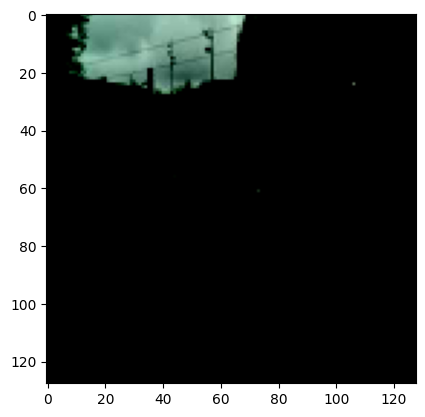

In [14]:
import matplotlib.pyplot as plt
import numpy as np

for X, y in trainloader:
    imageX = X[0]
    # imagey = y[0]

    imageX = imageX.permute(1, 2, 0).numpy()
    # imagey = imagey.permute(1, 2, 0).numpy()
    # Plot the image
    plt.imshow(imageX)
    # plt.imshow(imagey)
    plt.show()
    plt.show()
    break


In [31]:
import itertools

generatorX = Generator().to(ModelArgs.device).apply(weights_init)
discriminatorY = PatchGAN().to(ModelArgs.device).apply(weights_init)
generatorY = Generator().to(ModelArgs.device).apply(weights_init)
discriminatorX = PatchGAN().to(ModelArgs.device).apply(weights_init)


loss_fn = nn.MSELoss()  
epochs = 200 

generatorX.train()
discriminatorX.train()
generatorY.train()
discriminatorY.train()

optimizerG = torch.optim.Adam(itertools.chain(generatorX.parameters(), generatorY.parameters()), betas=(ModelArgs.beta_1, ModelArgs.beta_2), lr=ModelArgs.lr) #For discriminator
optimizerD = torch.optim.Adam(itertools.chain(discriminatorY.parameters(), discriminatorX.parameters()), betas=(ModelArgs.beta_1, ModelArgs.beta_2), lr=ModelArgs.lr) #For generator



real_label = 1
fake_label = 0


loss_g = []
loss_d = []
img_list = []


In [35]:
class CustomLRScheduler:
    def __init__(self, optimizers, total_epochs, lr_initial):
        self.optimizers = optimizers
        self.total_epochs = total_epochs
        self.lr_initial = lr_initial

    def step(self, epoch):
        if epoch < 100:
            lr = self.lr_initial
        else:
            decay = (self.lr_initial / 100) * (epoch - 100)
            lr = max(0, self.lr_initial - decay)
        
        for optimizer in self.optimizers:
            for param_group in optimizer.param_groups:
                param_group['lr'] = lr


In [36]:
epochs = 200
scheduler = CustomLRScheduler([optimizerG, optimizerD], epochs, lr_initial=ModelArgs.lr)

In [37]:
#Training loop

from tqdm import tqdm

iters = 0
g_scaler = torch.cuda.amp.GradScaler()
d_scaler = torch.cuda.amp.GradScaler()
 
writer_fake = SummaryWriter(f"logs/fake")
writer_real = SummaryWriter(f"logs/real")

img_counter = 0
for epoch in tqdm(range(epochs)):

    for X, y in trainloader:

    
        X = X.to(ModelArgs.device)
        y = y.to(ModelArgs.device)
        if(img_counter > 50):
            img_counter = 0
            
        
        #############################
        # Discriminator Training
        #############################
        
        with torch.cuda.amp.autocast():
            #Enabling the discriminators trainable ability 
            for params in discriminatorX.parameters():
                params.requires_grad = True            
                
            current_batch_size = X.shape[0]  #Getting the current batch size
            
            real_data = torch.ones((current_batch_size,), device=ModelArgs.device)

            # 1. Forward pass
            y_pred = discriminatorX(X)
            # print(y_pred)
            # print(y_pred.shape)
            # 2. Calculate  and accumulate loss
            loss_real = loss_fn(y_pred, real_data)

            # 3. Optimizer zero grad
            optimizerD.zero_grad()

        
            # loss_real.backward()


            #Train the discriminator (with fake data)

            # noise = torch.randn((batch_size, latent_vector_size, 1, 1), device=device)
            fake_data = torch.zeros(( current_batch_size,), device=ModelArgs.device)
            mask_generated_by_generatorY = generatorY(y)

            #1. Forward pass
            y_pred = discriminatorX(mask_generated_by_generatorY.detach())


            # 2. Calculate  and accumulate loss
            loss_fake = loss_fn(y_pred, fake_data)


            #Accumulating total discriminator loss
            discriminatorX_combined_loss = (loss_real + loss_fake) 
            # loss_d.append(discriminator_combined_loss.item())

            
            
            #Enabling the discriminators trainable ability 
            for params in discriminatorY.parameters():
                params.requires_grad = True            
                
            current_batch_size = X.shape[0]  #Getting the current batch size
            
            real_data = torch.ones((current_batch_size,), device=ModelArgs.device)

            # 1. Forward pass
            y_pred = discriminatorY(y)
            # print(y_pred.shape)
            
            # 2. Calculate  and accumulate loss
            loss_real = loss_fn(y_pred, real_data)


            #Train the discriminator (with fake data)

            # noise = torch.randn((batch_size, latent_vector_size, 1, 1), device=device)
            fake_data = torch.zeros(( current_batch_size,), device=ModelArgs.device)
            mask_generated_by_generatorX = generatorX(X)

            #1. Forward pass
            y_pred = discriminatorY(mask_generated_by_generatorX.detach())


            # 2. Calculate  and accumulate loss
            loss_fake = loss_fn(y_pred, fake_data)
            
            
            discriminatorY_combined_loss = (loss_real + loss_fake) 
            
            discriminator_combined_loss = (discriminatorX_combined_loss + discriminatorY_combined_loss) * 0.5
            
            
            # 4. Loss backward
            d_scaler.scale(discriminator_combined_loss).backward()
            
            # 5. Optimizer step
            d_scaler.step(optimizerD)
            d_scaler.update()
            

        ###########################
        # Generator Training
        ##########################
        with torch.cuda.amp.autocast():
            #Disabling the discriminators trainable ability 
            for params in discriminatorX.parameters():
                params.requires_grad = False
            
            #Disabling the discriminators trainable ability 
            for params in discriminatorY.parameters():
                params.requires_grad = False
                
            # mask_generated_by_generator = unet(X)
            labels = torch.ones((current_batch_size,), device=ModelArgs.device)

            #1. Forward pass
            y_pred = discriminatorX(mask_generated_by_generatorY)
            # y_pred = torch.argmax(probs, dim=1).type(torch.float32)


            #2. Calculate and accumulate loss
            loss_geny = loss_fn(y_pred,labels) 
            
    
            # mask_generated_by_generator = unet(X)
            labels = torch.ones((current_batch_size,), device=ModelArgs.device)

            #1. Forward pass
            y_pred = discriminatorY(mask_generated_by_generatorX)
            # y_pred = torch.argmax(probs, dim=1).type(torch.float32)


            #2. Calculate and accumulate loss
            loss_genx = loss_fn(y_pred,labels) 
            # print(loss_geny)
            # print(loss_genx)
            # print(nn.functional.l1_loss(mask_generated_by_generatorY, X))
            # print(nn.functional.l1_loss(mask_generated_by_generatorX, y))
            identity_genx = nn.functional.l1_loss(mask_generated_by_generatorX, y)
            identity_geny = nn.functional.l1_loss(mask_generated_by_generatorY, X)
            combined_generator_loss = (loss_geny + loss_genx + identity_genx + identity_geny) +  ModelArgs.lambda_gen * (nn.functional.l1_loss(mask_generated_by_generatorY, X) + nn.functional.l1_loss(mask_generated_by_generatorX, y))

            # 3. Optimizer zero grad
            optimizerG.zero_grad()

            # 4. Loss backward
            g_scaler.scale(combined_generator_loss).backward()

            # 5. Optimizer step
            g_scaler.step(optimizerG)
            g_scaler.update()
        
        
        

        if iters % 200 == 0:
            print("Iterations: ", iters, "Epoch: ", epoch, "Generator loss: ", combined_generator_loss.item(), "Discriminator loss: ", discriminator_combined_loss.item())

    
        if iters % 500 == 0:
            
            print('saving the output')
            torchvision.utils.save_image(X* 0.5 + 0.5,'{}/realB_images_iters_{}.png'.format(save_images, iters))
            torchvision.utils.save_image(y* 0.5 + 0.5,'{}/realA_images_iters_{}.png'.format(save_images, iters))
            # fakeA = generatorX(X)
            # fakeB = generatorY(y)
            torchvision.utils.save_image(mask_generated_by_generatorX* 0.5 + 0.5,'{}/fake_imageA_iters_{}.png'.format(save_images, iters))
            torchvision.utils.save_image(mask_generated_by_generatorY* 0.5 + 0.5,'{}/fake_imageB_iters_{}.png'.format(save_images, iters))


            img_grid_fakeA = torchvision.utils.make_grid(mask_generated_by_generatorX, normalize=True)
            img_grid_fakeB = torchvision.utils.make_grid(mask_generated_by_generatorY, normalize=True)
            # img_grid_map = torchvision.utils.make_grid(X, normalize=True)
                
            writer_fake.add_image(
                        "Cityscapes2lables FakeA Images", img_grid_fakeA, global_step=iters
                    )
            writer_real.add_image(
                        "Cityscapes2lables FakeB Images", img_grid_fakeB, global_step=iters
                    )
            
            # writer_real.add_image(
            #             "Map2Aerial Aerial Images", img_grid_map, global_step=iters
            #         )
                    

            # Check pointing for every epoch
            # torch.save(generator.state_dict(), 'weights/CelebA/generator_steps_%d.pth' % (iters))
            # torch.save(discriminator.state_dict(), 'weights/CelebA/discriminator_steps_%d.pth' % (iters))


        iters += 1
        
    scheduler.step(epoch)

  0%|          | 0/200 [00:00<?, ?it/s]

Iterations:  0 Epoch:  0 Generator loss:  6.708699703216553 Discriminator loss:  0.5348831415176392
saving the output
Iterations:  200 Epoch:  0 Generator loss:  5.203976154327393 Discriminator loss:  0.2515261173248291
Iterations:  400 Epoch:  0 Generator loss:  6.677587509155273 Discriminator loss:  0.0666915699839592
saving the output
Iterations:  600 Epoch:  0 Generator loss:  7.081015586853027 Discriminator loss:  0.17069436609745026
Iterations:  800 Epoch:  0 Generator loss:  6.076804161071777 Discriminator loss:  0.25835809111595154
Iterations:  1000 Epoch:  0 Generator loss:  7.259548187255859 Discriminator loss:  0.13021402060985565
saving the output
Iterations:  1200 Epoch:  0 Generator loss:  7.133435249328613 Discriminator loss:  0.11250948160886765
Iterations:  1400 Epoch:  0 Generator loss:  4.916278839111328 Discriminator loss:  0.23098018765449524
saving the output
Iterations:  1600 Epoch:  0 Generator loss:  5.140400409698486 Discriminator loss:  0.09743780642747879
It

  0%|          | 1/200 [04:23<14:35:33, 263.99s/it]

Iterations:  3000 Epoch:  1 Generator loss:  6.0975189208984375 Discriminator loss:  0.11171866208314896
saving the output
Iterations:  3200 Epoch:  1 Generator loss:  6.1937079429626465 Discriminator loss:  0.03489059954881668
Iterations:  3400 Epoch:  1 Generator loss:  5.815217018127441 Discriminator loss:  0.055435605347156525
saving the output
Iterations:  3600 Epoch:  1 Generator loss:  6.701831340789795 Discriminator loss:  0.11054302752017975
Iterations:  3800 Epoch:  1 Generator loss:  5.090155124664307 Discriminator loss:  0.13664036989212036
Iterations:  4000 Epoch:  1 Generator loss:  9.326272010803223 Discriminator loss:  0.2142733335494995
saving the output
Iterations:  4200 Epoch:  1 Generator loss:  7.50077486038208 Discriminator loss:  0.520683228969574
Iterations:  4400 Epoch:  1 Generator loss:  7.051923751831055 Discriminator loss:  0.0616147480905056
saving the output
Iterations:  4600 Epoch:  1 Generator loss:  5.758209228515625 Discriminator loss:  0.111467570066

  1%|          | 2/200 [08:41<14:18:55, 260.28s/it]

Iterations:  6000 Epoch:  2 Generator loss:  5.744756698608398 Discriminator loss:  0.06274042278528214
saving the output
Iterations:  6200 Epoch:  2 Generator loss:  5.3473591804504395 Discriminator loss:  0.4946279227733612
Iterations:  6400 Epoch:  2 Generator loss:  5.403684616088867 Discriminator loss:  0.4132544696331024
saving the output
Iterations:  6600 Epoch:  2 Generator loss:  7.198941230773926 Discriminator loss:  0.15593205392360687
Iterations:  6800 Epoch:  2 Generator loss:  5.218955039978027 Discriminator loss:  0.2579195499420166
Iterations:  7000 Epoch:  2 Generator loss:  5.382177829742432 Discriminator loss:  0.06357689946889877
saving the output
Iterations:  7200 Epoch:  2 Generator loss:  5.155367374420166 Discriminator loss:  0.29857945442199707
Iterations:  7400 Epoch:  2 Generator loss:  5.255902290344238 Discriminator loss:  0.4199935793876648
saving the output
Iterations:  7600 Epoch:  2 Generator loss:  6.413141250610352 Discriminator loss:  0.2845469117164

  2%|▏         | 3/200 [13:01<14:13:44, 260.02s/it]

Iterations:  9000 Epoch:  3 Generator loss:  6.281662464141846 Discriminator loss:  0.10827011615037918
saving the output
Iterations:  9200 Epoch:  3 Generator loss:  5.05148983001709 Discriminator loss:  0.016077890992164612
Iterations:  9400 Epoch:  3 Generator loss:  4.107664108276367 Discriminator loss:  0.39933088421821594
saving the output
Iterations:  9600 Epoch:  3 Generator loss:  6.74880313873291 Discriminator loss:  0.05761769041419029
Iterations:  9800 Epoch:  3 Generator loss:  4.775546073913574 Discriminator loss:  0.3415221571922302
Iterations:  10000 Epoch:  3 Generator loss:  6.20522403717041 Discriminator loss:  0.12782111763954163
saving the output
Iterations:  10200 Epoch:  3 Generator loss:  5.792580604553223 Discriminator loss:  0.11137313395738602
Iterations:  10400 Epoch:  3 Generator loss:  6.924965858459473 Discriminator loss:  0.022540302947163582
saving the output
Iterations:  10600 Epoch:  3 Generator loss:  4.39582633972168 Discriminator loss:  0.160450771

  2%|▏         | 4/200 [17:22<14:10:28, 260.35s/it]

Iterations:  12000 Epoch:  4 Generator loss:  6.820244789123535 Discriminator loss:  0.01838233880698681
saving the output
Iterations:  12200 Epoch:  4 Generator loss:  6.3041582107543945 Discriminator loss:  0.13052543997764587
Iterations:  12400 Epoch:  4 Generator loss:  4.549004554748535 Discriminator loss:  0.12488727271556854
saving the output
Iterations:  12600 Epoch:  4 Generator loss:  4.933528900146484 Discriminator loss:  0.03652666136622429
Iterations:  12800 Epoch:  4 Generator loss:  4.687222003936768 Discriminator loss:  0.3113665282726288
Iterations:  13000 Epoch:  4 Generator loss:  7.224271297454834 Discriminator loss:  0.07314250618219376
saving the output
Iterations:  13200 Epoch:  4 Generator loss:  4.205132484436035 Discriminator loss:  0.45997554063796997
Iterations:  13400 Epoch:  4 Generator loss:  4.42527437210083 Discriminator loss:  0.1481349617242813
saving the output
Iterations:  13600 Epoch:  4 Generator loss:  4.655445098876953 Discriminator loss:  0.020

  2%|▎         | 5/200 [21:43<14:06:46, 260.55s/it]

Iterations:  15000 Epoch:  5 Generator loss:  5.247339248657227 Discriminator loss:  0.1404014378786087
saving the output
Iterations:  15200 Epoch:  5 Generator loss:  4.586800575256348 Discriminator loss:  0.1789705604314804
Iterations:  15400 Epoch:  5 Generator loss:  6.146969795227051 Discriminator loss:  0.061508625745773315
saving the output
Iterations:  15600 Epoch:  5 Generator loss:  6.017836570739746 Discriminator loss:  0.09889509528875351
Iterations:  15800 Epoch:  5 Generator loss:  4.95614767074585 Discriminator loss:  0.016653407365083694
Iterations:  16000 Epoch:  5 Generator loss:  4.579340934753418 Discriminator loss:  0.23462547361850739
saving the output
Iterations:  16200 Epoch:  5 Generator loss:  6.364041328430176 Discriminator loss:  0.02177181839942932
Iterations:  16400 Epoch:  5 Generator loss:  4.310430526733398 Discriminator loss:  0.2032785564661026
saving the output
Iterations:  16600 Epoch:  5 Generator loss:  4.360827922821045 Discriminator loss:  0.188

  3%|▎         | 6/200 [26:04<14:02:56, 260.70s/it]

Iterations:  18000 Epoch:  6 Generator loss:  4.345767498016357 Discriminator loss:  0.03944769874215126
saving the output
Iterations:  18200 Epoch:  6 Generator loss:  5.767243385314941 Discriminator loss:  0.04540200158953667
Iterations:  18400 Epoch:  6 Generator loss:  5.212712287902832 Discriminator loss:  0.412686288356781
saving the output
Iterations:  18600 Epoch:  6 Generator loss:  4.921520709991455 Discriminator loss:  0.1621008962392807
Iterations:  18800 Epoch:  6 Generator loss:  5.760316848754883 Discriminator loss:  0.007096417248249054
Iterations:  19000 Epoch:  6 Generator loss:  5.1759419441223145 Discriminator loss:  0.11471185088157654
saving the output
Iterations:  19200 Epoch:  6 Generator loss:  6.058907508850098 Discriminator loss:  0.2811061143875122
Iterations:  19400 Epoch:  6 Generator loss:  5.112576007843018 Discriminator loss:  0.003025298472493887
saving the output
Iterations:  19600 Epoch:  6 Generator loss:  6.220129013061523 Discriminator loss:  0.03

  4%|▎         | 7/200 [30:25<13:59:34, 261.01s/it]

Iterations:  21000 Epoch:  7 Generator loss:  4.699504852294922 Discriminator loss:  0.02288646809756756
saving the output
Iterations:  21200 Epoch:  7 Generator loss:  8.11343002319336 Discriminator loss:  0.0023937998339533806
Iterations:  21400 Epoch:  7 Generator loss:  6.3018107414245605 Discriminator loss:  0.005048543214797974
saving the output
Iterations:  21600 Epoch:  7 Generator loss:  5.505552768707275 Discriminator loss:  0.19376900792121887
Iterations:  21800 Epoch:  7 Generator loss:  5.702380180358887 Discriminator loss:  0.04062590375542641
Iterations:  22000 Epoch:  7 Generator loss:  5.240809440612793 Discriminator loss:  0.014265637844800949
saving the output
Iterations:  22200 Epoch:  7 Generator loss:  5.3186869621276855 Discriminator loss:  0.02303050085902214
Iterations:  22400 Epoch:  7 Generator loss:  4.326444149017334 Discriminator loss:  0.17606347799301147
saving the output
Iterations:  22600 Epoch:  7 Generator loss:  5.6157755851745605 Discriminator loss

  4%|▍         | 8/200 [34:44<13:53:18, 260.41s/it]

Iterations:  23800 Epoch:  8 Generator loss:  4.359940528869629 Discriminator loss:  0.023425936698913574
Iterations:  24000 Epoch:  8 Generator loss:  5.276801586151123 Discriminator loss:  0.0005441265529952943
saving the output
Iterations:  24200 Epoch:  8 Generator loss:  6.398956298828125 Discriminator loss:  0.01063800323754549
Iterations:  24400 Epoch:  8 Generator loss:  5.653749942779541 Discriminator loss:  0.02690901979804039
saving the output
Iterations:  24600 Epoch:  8 Generator loss:  5.28125 Discriminator loss:  9.260952356271446e-05
Iterations:  24800 Epoch:  8 Generator loss:  3.847710609436035 Discriminator loss:  0.04283488169312477
Iterations:  25000 Epoch:  8 Generator loss:  4.753458023071289 Discriminator loss:  2.5059955078177154e-05
saving the output
Iterations:  25200 Epoch:  8 Generator loss:  4.616961479187012 Discriminator loss:  0.0038702532183378935
Iterations:  25400 Epoch:  8 Generator loss:  6.429450035095215 Discriminator loss:  0.0018830427434295416

  4%|▍         | 9/200 [39:06<13:50:27, 260.88s/it]

Iterations:  26800 Epoch:  9 Generator loss:  7.896202087402344 Discriminator loss:  0.00690286373719573
Iterations:  27000 Epoch:  9 Generator loss:  4.978006362915039 Discriminator loss:  0.2436208575963974
saving the output
Iterations:  27200 Epoch:  9 Generator loss:  5.530712127685547 Discriminator loss:  0.00010854944412130862
Iterations:  27400 Epoch:  9 Generator loss:  5.897121906280518 Discriminator loss:  7.672323408769444e-05
saving the output
Iterations:  27600 Epoch:  9 Generator loss:  5.168020248413086 Discriminator loss:  0.00010309709614375606
Iterations:  27800 Epoch:  9 Generator loss:  5.309312343597412 Discriminator loss:  1.401092049491126e-06
Iterations:  28000 Epoch:  9 Generator loss:  6.119907855987549 Discriminator loss:  1.1468866887298645e-06
saving the output
Iterations:  28200 Epoch:  9 Generator loss:  5.335239887237549 Discriminator loss:  0.0005214441334828734
Iterations:  28400 Epoch:  9 Generator loss:  5.424972057342529 Discriminator loss:  0.00130

  5%|▌         | 10/200 [43:28<13:46:56, 261.14s/it]

Iterations:  29800 Epoch:  10 Generator loss:  6.232028007507324 Discriminator loss:  0.01991034485399723
Iterations:  30000 Epoch:  10 Generator loss:  5.703459739685059 Discriminator loss:  0.36139416694641113
saving the output
Iterations:  30200 Epoch:  10 Generator loss:  5.505306720733643 Discriminator loss:  0.1534269005060196
Iterations:  30400 Epoch:  10 Generator loss:  4.283215045928955 Discriminator loss:  0.26844149827957153
saving the output
Iterations:  30600 Epoch:  10 Generator loss:  4.232552528381348 Discriminator loss:  0.3427964746952057
Iterations:  30800 Epoch:  10 Generator loss:  4.472243309020996 Discriminator loss:  0.25669345259666443
Iterations:  31000 Epoch:  10 Generator loss:  4.853731155395508 Discriminator loss:  0.36696675419807434
saving the output
Iterations:  31200 Epoch:  10 Generator loss:  5.3507256507873535 Discriminator loss:  0.01954314112663269
Iterations:  31400 Epoch:  10 Generator loss:  4.404268264770508 Discriminator loss:  0.03100927360

  6%|▌         | 11/200 [47:53<13:46:02, 262.23s/it]

Iterations:  32800 Epoch:  11 Generator loss:  5.783968925476074 Discriminator loss:  0.37752965092658997
Iterations:  33000 Epoch:  11 Generator loss:  4.687539577484131 Discriminator loss:  0.023117348551750183
saving the output
Iterations:  33200 Epoch:  11 Generator loss:  4.671928882598877 Discriminator loss:  0.004135406110435724
Iterations:  33400 Epoch:  11 Generator loss:  6.200268268585205 Discriminator loss:  0.14843495190143585
saving the output
Iterations:  33600 Epoch:  11 Generator loss:  4.0218186378479 Discriminator loss:  0.2562597393989563
Iterations:  33800 Epoch:  11 Generator loss:  4.672245979309082 Discriminator loss:  0.2943207323551178
Iterations:  34000 Epoch:  11 Generator loss:  4.333047389984131 Discriminator loss:  0.0077803367748856544
saving the output
Iterations:  34200 Epoch:  11 Generator loss:  4.370416641235352 Discriminator loss:  0.2699934244155884
Iterations:  34400 Epoch:  11 Generator loss:  4.354297637939453 Discriminator loss:  0.04983950778

  6%|▌         | 12/200 [52:11<13:38:06, 261.10s/it]

Iterations:  35800 Epoch:  12 Generator loss:  4.897019863128662 Discriminator loss:  0.0005224412307143211
Iterations:  36000 Epoch:  12 Generator loss:  6.6838603019714355 Discriminator loss:  0.043168507516384125
saving the output
Iterations:  36200 Epoch:  12 Generator loss:  5.687010765075684 Discriminator loss:  0.0202175285667181
Iterations:  36400 Epoch:  12 Generator loss:  5.678041458129883 Discriminator loss:  0.006086232140660286
saving the output
Iterations:  36600 Epoch:  12 Generator loss:  4.1939005851745605 Discriminator loss:  0.271390438079834
Iterations:  36800 Epoch:  12 Generator loss:  5.655967712402344 Discriminator loss:  0.0009284982224926353
Iterations:  37000 Epoch:  12 Generator loss:  4.923242568969727 Discriminator loss:  0.010931129567325115
saving the output
Iterations:  37200 Epoch:  12 Generator loss:  4.370917320251465 Discriminator loss:  0.5576494932174683
Iterations:  37400 Epoch:  12 Generator loss:  5.364428997039795 Discriminator loss:  0.09883

  6%|▋         | 13/200 [56:34<13:34:51, 261.45s/it]

Iterations:  38800 Epoch:  13 Generator loss:  4.4771528244018555 Discriminator loss:  0.010197225026786327
Iterations:  39000 Epoch:  13 Generator loss:  5.552740097045898 Discriminator loss:  0.008986513130366802
saving the output
Iterations:  39200 Epoch:  13 Generator loss:  5.970076560974121 Discriminator loss:  0.005620461888611317
Iterations:  39400 Epoch:  13 Generator loss:  4.457176685333252 Discriminator loss:  0.03424521163105965
saving the output
Iterations:  39600 Epoch:  13 Generator loss:  4.001874923706055 Discriminator loss:  0.007389607839286327
Iterations:  39800 Epoch:  13 Generator loss:  4.73789119720459 Discriminator loss:  0.3447951078414917
Iterations:  40000 Epoch:  13 Generator loss:  5.227724075317383 Discriminator loss:  0.03765265271067619
saving the output
Iterations:  40200 Epoch:  13 Generator loss:  5.807317733764648 Discriminator loss:  0.012874052859842777
Iterations:  40400 Epoch:  13 Generator loss:  6.392054557800293 Discriminator loss:  0.013608

  7%|▋         | 14/200 [1:00:55<13:30:23, 261.42s/it]

Iterations:  41800 Epoch:  14 Generator loss:  5.938471794128418 Discriminator loss:  0.17135748267173767
Iterations:  42000 Epoch:  14 Generator loss:  5.578055381774902 Discriminator loss:  0.09661553055047989
saving the output
Iterations:  42200 Epoch:  14 Generator loss:  6.481186866760254 Discriminator loss:  0.029261216521263123
Iterations:  42400 Epoch:  14 Generator loss:  5.258734703063965 Discriminator loss:  0.07876349240541458
saving the output
Iterations:  42600 Epoch:  14 Generator loss:  4.644342422485352 Discriminator loss:  0.3020419776439667
Iterations:  42800 Epoch:  14 Generator loss:  4.436752796173096 Discriminator loss:  0.2825729548931122
Iterations:  43000 Epoch:  14 Generator loss:  5.5708417892456055 Discriminator loss:  0.05654267594218254
saving the output
Iterations:  43200 Epoch:  14 Generator loss:  4.758979797363281 Discriminator loss:  0.19468405842781067
Iterations:  43400 Epoch:  14 Generator loss:  5.3468217849731445 Discriminator loss:  0.088432051

  8%|▊         | 15/200 [1:05:16<13:26:00, 261.41s/it]

Iterations:  44800 Epoch:  15 Generator loss:  6.4676513671875 Discriminator loss:  0.18139666318893433
Iterations:  45000 Epoch:  15 Generator loss:  4.827067852020264 Discriminator loss:  0.3243553936481476
saving the output
Iterations:  45200 Epoch:  15 Generator loss:  5.822416305541992 Discriminator loss:  0.21971693634986877
Iterations:  45400 Epoch:  15 Generator loss:  5.465339183807373 Discriminator loss:  0.3246728181838989
saving the output
Iterations:  45600 Epoch:  15 Generator loss:  4.676181793212891 Discriminator loss:  0.0032649117056280375
Iterations:  45800 Epoch:  15 Generator loss:  6.779277801513672 Discriminator loss:  0.017386505380272865
Iterations:  46000 Epoch:  15 Generator loss:  4.834181308746338 Discriminator loss:  0.19342170655727386
saving the output
Iterations:  46200 Epoch:  15 Generator loss:  3.893209457397461 Discriminator loss:  0.2646956145763397
Iterations:  46400 Epoch:  15 Generator loss:  6.275901794433594 Discriminator loss:  0.119419656693

  8%|▊         | 16/200 [1:09:39<13:22:44, 261.76s/it]

Iterations:  47600 Epoch:  16 Generator loss:  4.826265335083008 Discriminator loss:  0.3087726831436157
Iterations:  47800 Epoch:  16 Generator loss:  3.689225196838379 Discriminator loss:  0.07027096301317215
Iterations:  48000 Epoch:  16 Generator loss:  4.5363359451293945 Discriminator loss:  0.022855164483189583
saving the output
Iterations:  48200 Epoch:  16 Generator loss:  4.754981517791748 Discriminator loss:  0.17957577109336853
Iterations:  48400 Epoch:  16 Generator loss:  5.821348667144775 Discriminator loss:  0.06069493666291237
saving the output
Iterations:  48600 Epoch:  16 Generator loss:  4.051423072814941 Discriminator loss:  0.32006269693374634
Iterations:  48800 Epoch:  16 Generator loss:  6.804332733154297 Discriminator loss:  0.023886272683739662
Iterations:  49000 Epoch:  16 Generator loss:  5.247375965118408 Discriminator loss:  0.040916819125413895
saving the output
Iterations:  49200 Epoch:  16 Generator loss:  4.216968059539795 Discriminator loss:  0.0467899

  8%|▊         | 17/200 [1:14:01<13:18:49, 261.91s/it]

Iterations:  50600 Epoch:  17 Generator loss:  5.438179016113281 Discriminator loss:  0.1446305513381958
Iterations:  50800 Epoch:  17 Generator loss:  6.1327619552612305 Discriminator loss:  0.06842456012964249
Iterations:  51000 Epoch:  17 Generator loss:  4.765753746032715 Discriminator loss:  0.21722328662872314
saving the output
Iterations:  51200 Epoch:  17 Generator loss:  6.137217998504639 Discriminator loss:  0.25223636627197266
Iterations:  51400 Epoch:  17 Generator loss:  5.899862289428711 Discriminator loss:  0.12081612646579742
saving the output
Iterations:  51600 Epoch:  17 Generator loss:  4.917133331298828 Discriminator loss:  0.018540935590863228
Iterations:  51800 Epoch:  17 Generator loss:  5.279425621032715 Discriminator loss:  0.019214913249015808
Iterations:  52000 Epoch:  17 Generator loss:  5.205204010009766 Discriminator loss:  0.09198809415102005
saving the output
Iterations:  52200 Epoch:  17 Generator loss:  4.1646223068237305 Discriminator loss:  0.2413970

  9%|▉         | 18/200 [1:18:24<13:15:12, 262.15s/it]

Iterations:  53600 Epoch:  18 Generator loss:  4.85172700881958 Discriminator loss:  0.01262199692428112
Iterations:  53800 Epoch:  18 Generator loss:  4.063826560974121 Discriminator loss:  0.28281110525131226
Iterations:  54000 Epoch:  18 Generator loss:  4.970468521118164 Discriminator loss:  0.012656992301344872
saving the output
Iterations:  54200 Epoch:  18 Generator loss:  5.261064052581787 Discriminator loss:  0.056462012231349945
Iterations:  54400 Epoch:  18 Generator loss:  4.980021953582764 Discriminator loss:  0.00011680804163916036
saving the output
Iterations:  54600 Epoch:  18 Generator loss:  5.640429973602295 Discriminator loss:  0.35297706723213196
Iterations:  54800 Epoch:  18 Generator loss:  6.2031731605529785 Discriminator loss:  0.0020623337477445602
Iterations:  55000 Epoch:  18 Generator loss:  5.839032173156738 Discriminator loss:  0.018553949892520905
saving the output
Iterations:  55200 Epoch:  18 Generator loss:  4.547971248626709 Discriminator loss:  0.00

 10%|▉         | 19/200 [1:22:45<13:09:47, 261.81s/it]

Iterations:  56600 Epoch:  19 Generator loss:  4.928674221038818 Discriminator loss:  0.0033988477662205696
Iterations:  56800 Epoch:  19 Generator loss:  5.805076599121094 Discriminator loss:  0.36387762427330017
Iterations:  57000 Epoch:  19 Generator loss:  6.208641529083252 Discriminator loss:  0.0488341748714447
saving the output
Iterations:  57200 Epoch:  19 Generator loss:  5.441584587097168 Discriminator loss:  0.011662401258945465
Iterations:  57400 Epoch:  19 Generator loss:  4.398116111755371 Discriminator loss:  0.33272409439086914
saving the output
Iterations:  57600 Epoch:  19 Generator loss:  4.563220977783203 Discriminator loss:  0.11863573640584946
Iterations:  57800 Epoch:  19 Generator loss:  4.594087600708008 Discriminator loss:  0.18366403877735138
Iterations:  58000 Epoch:  19 Generator loss:  5.52425479888916 Discriminator loss:  0.006055793724954128
saving the output
Iterations:  58200 Epoch:  19 Generator loss:  5.472982883453369 Discriminator loss:  0.00311622

 10%|█         | 20/200 [1:27:08<13:07:03, 262.35s/it]

saving the output
Iterations:  59600 Epoch:  20 Generator loss:  6.814333915710449 Discriminator loss:  0.2749975025653839
Iterations:  59800 Epoch:  20 Generator loss:  4.964714050292969 Discriminator loss:  0.012381670996546745
Iterations:  60000 Epoch:  20 Generator loss:  5.131712913513184 Discriminator loss:  0.07269949465990067
saving the output
Iterations:  60200 Epoch:  20 Generator loss:  4.96057653427124 Discriminator loss:  0.15989884734153748
Iterations:  60400 Epoch:  20 Generator loss:  5.1419782638549805 Discriminator loss:  0.4872038960456848
saving the output
Iterations:  60600 Epoch:  20 Generator loss:  5.800551414489746 Discriminator loss:  0.007711526472121477
Iterations:  60800 Epoch:  20 Generator loss:  6.502164840698242 Discriminator loss:  0.02310751937329769
Iterations:  61000 Epoch:  20 Generator loss:  5.493851661682129 Discriminator loss:  0.0001172177362604998
saving the output
Iterations:  61200 Epoch:  20 Generator loss:  4.380703926086426 Discriminator

 10%|█         | 21/200 [1:31:32<13:03:46, 262.72s/it]

saving the output
Iterations:  62600 Epoch:  21 Generator loss:  4.961390972137451 Discriminator loss:  0.010418296791613102
Iterations:  62800 Epoch:  21 Generator loss:  5.606437683105469 Discriminator loss:  0.009186245501041412
Iterations:  63000 Epoch:  21 Generator loss:  4.510037422180176 Discriminator loss:  0.015772776678204536
saving the output
Iterations:  63200 Epoch:  21 Generator loss:  4.424904823303223 Discriminator loss:  0.05596138909459114
Iterations:  63400 Epoch:  21 Generator loss:  5.411887168884277 Discriminator loss:  0.11810289323329926
saving the output
Iterations:  63600 Epoch:  21 Generator loss:  6.205061912536621 Discriminator loss:  0.008973483927547932
Iterations:  63800 Epoch:  21 Generator loss:  5.7750630378723145 Discriminator loss:  0.19117256999015808
Iterations:  64000 Epoch:  21 Generator loss:  4.300204277038574 Discriminator loss:  0.13792340457439423
saving the output
Iterations:  64200 Epoch:  21 Generator loss:  4.755207538604736 Discrimina

 11%|█         | 22/200 [1:35:53<12:57:57, 262.24s/it]

saving the output
Iterations:  65600 Epoch:  22 Generator loss:  5.6321611404418945 Discriminator loss:  0.015303950756788254
Iterations:  65800 Epoch:  22 Generator loss:  4.381168842315674 Discriminator loss:  0.031027812510728836
Iterations:  66000 Epoch:  22 Generator loss:  5.371054172515869 Discriminator loss:  0.0005803672247566283
saving the output
Iterations:  66200 Epoch:  22 Generator loss:  3.4883971214294434 Discriminator loss:  0.20615215599536896
Iterations:  66400 Epoch:  22 Generator loss:  4.833785533905029 Discriminator loss:  0.04009350761771202
saving the output
Iterations:  66600 Epoch:  22 Generator loss:  6.034636974334717 Discriminator loss:  0.3623753786087036
Iterations:  66800 Epoch:  22 Generator loss:  5.236799716949463 Discriminator loss:  0.03693097457289696
Iterations:  67000 Epoch:  22 Generator loss:  4.819069862365723 Discriminator loss:  0.005298915319144726
saving the output
Iterations:  67200 Epoch:  22 Generator loss:  4.410893440246582 Discrimin

 12%|█▏        | 23/200 [1:40:13<12:51:30, 261.53s/it]

saving the output
Iterations:  68600 Epoch:  23 Generator loss:  3.688498020172119 Discriminator loss:  0.03775421157479286
Iterations:  68800 Epoch:  23 Generator loss:  7.173735618591309 Discriminator loss:  0.10018739849328995
Iterations:  69000 Epoch:  23 Generator loss:  4.663750171661377 Discriminator loss:  0.015479104593396187
saving the output
Iterations:  69200 Epoch:  23 Generator loss:  4.933374881744385 Discriminator loss:  1.4815675967838615e-05
Iterations:  69400 Epoch:  23 Generator loss:  5.240438461303711 Discriminator loss:  0.3154400885105133
saving the output
Iterations:  69600 Epoch:  23 Generator loss:  4.333023548126221 Discriminator loss:  0.2737322449684143
Iterations:  69800 Epoch:  23 Generator loss:  4.84531307220459 Discriminator loss:  0.06233351305127144
Iterations:  70000 Epoch:  23 Generator loss:  4.534336090087891 Discriminator loss:  0.2748080790042877
saving the output
Iterations:  70200 Epoch:  23 Generator loss:  4.862748146057129 Discriminator l

 12%|█▏        | 24/200 [1:44:31<12:44:23, 260.59s/it]

Iterations:  71400 Epoch:  24 Generator loss:  4.569181442260742 Discriminator loss:  0.019211139529943466
saving the output
Iterations:  71600 Epoch:  24 Generator loss:  4.9744720458984375 Discriminator loss:  0.04398343339562416
Iterations:  71800 Epoch:  24 Generator loss:  5.173403739929199 Discriminator loss:  6.0924532590433955e-05
Iterations:  72000 Epoch:  24 Generator loss:  3.588599920272827 Discriminator loss:  0.11885285377502441
saving the output
Iterations:  72200 Epoch:  24 Generator loss:  5.236461639404297 Discriminator loss:  0.0569976270198822
Iterations:  72400 Epoch:  24 Generator loss:  4.393337249755859 Discriminator loss:  0.011493663303554058
saving the output
Iterations:  72600 Epoch:  24 Generator loss:  4.885525703430176 Discriminator loss:  0.02824530191719532
Iterations:  72800 Epoch:  24 Generator loss:  4.034145832061768 Discriminator loss:  0.08679676055908203
Iterations:  73000 Epoch:  24 Generator loss:  4.076969623565674 Discriminator loss:  0.00249

 12%|█▎        | 25/200 [1:48:52<12:40:18, 260.68s/it]

Iterations:  74400 Epoch:  25 Generator loss:  4.502988338470459 Discriminator loss:  0.2495540827512741
saving the output
Iterations:  74600 Epoch:  25 Generator loss:  5.325099468231201 Discriminator loss:  0.2664666771888733
Iterations:  74800 Epoch:  25 Generator loss:  6.788956642150879 Discriminator loss:  6.48907371214591e-06
Iterations:  75000 Epoch:  25 Generator loss:  5.26971435546875 Discriminator loss:  0.017627401277422905
saving the output
Iterations:  75200 Epoch:  25 Generator loss:  4.770585060119629 Discriminator loss:  0.23480910062789917
Iterations:  75400 Epoch:  25 Generator loss:  5.3263139724731445 Discriminator loss:  0.013234439305961132
saving the output
Iterations:  75600 Epoch:  25 Generator loss:  5.732395172119141 Discriminator loss:  0.002583148656412959
Iterations:  75800 Epoch:  25 Generator loss:  5.261772155761719 Discriminator loss:  0.003603206481784582
Iterations:  76000 Epoch:  25 Generator loss:  3.802104949951172 Discriminator loss:  0.0007170

 13%|█▎        | 26/200 [1:53:13<12:35:46, 260.61s/it]

Iterations:  77400 Epoch:  26 Generator loss:  4.843560218811035 Discriminator loss:  0.04173876345157623
saving the output
Iterations:  77600 Epoch:  26 Generator loss:  5.294904708862305 Discriminator loss:  0.12390733510255814
Iterations:  77800 Epoch:  26 Generator loss:  4.488085746765137 Discriminator loss:  0.008960102684795856
Iterations:  78000 Epoch:  26 Generator loss:  5.059422969818115 Discriminator loss:  0.0012182217324152589
saving the output
Iterations:  78200 Epoch:  26 Generator loss:  4.365337371826172 Discriminator loss:  0.002034625271335244
Iterations:  78400 Epoch:  26 Generator loss:  4.862937927246094 Discriminator loss:  0.0025234248023480177
saving the output
Iterations:  78600 Epoch:  26 Generator loss:  4.869572639465332 Discriminator loss:  0.06227266788482666
Iterations:  78800 Epoch:  26 Generator loss:  4.403558731079102 Discriminator loss:  0.01729450561106205
Iterations:  79000 Epoch:  26 Generator loss:  5.729500770568848 Discriminator loss:  0.0958

 14%|█▎        | 27/200 [1:57:34<12:32:19, 260.92s/it]

Iterations:  80400 Epoch:  27 Generator loss:  5.171204566955566 Discriminator loss:  0.002603495493531227
saving the output
Iterations:  80600 Epoch:  27 Generator loss:  4.330756187438965 Discriminator loss:  0.0016588162397965789
Iterations:  80800 Epoch:  27 Generator loss:  6.30449104309082 Discriminator loss:  0.1357412189245224
Iterations:  81000 Epoch:  27 Generator loss:  4.9388556480407715 Discriminator loss:  0.019457751885056496
saving the output
Iterations:  81200 Epoch:  27 Generator loss:  4.343408584594727 Discriminator loss:  0.006707302760332823
Iterations:  81400 Epoch:  27 Generator loss:  4.387594223022461 Discriminator loss:  0.0019395718118175864
saving the output
Iterations:  81600 Epoch:  27 Generator loss:  5.169225215911865 Discriminator loss:  0.017890166491270065
Iterations:  81800 Epoch:  27 Generator loss:  6.983119964599609 Discriminator loss:  0.008322794921696186
Iterations:  82000 Epoch:  27 Generator loss:  4.498047828674316 Discriminator loss:  0.01

 14%|█▍        | 28/200 [2:01:54<12:27:07, 260.63s/it]

Iterations:  83400 Epoch:  28 Generator loss:  4.804938316345215 Discriminator loss:  2.0718980522360653e-05
saving the output
Iterations:  83600 Epoch:  28 Generator loss:  4.270359039306641 Discriminator loss:  0.09013344347476959
Iterations:  83800 Epoch:  28 Generator loss:  4.577478408813477 Discriminator loss:  0.0007134320912882686
Iterations:  84000 Epoch:  28 Generator loss:  3.982635021209717 Discriminator loss:  0.13718636333942413
saving the output
Iterations:  84200 Epoch:  28 Generator loss:  5.812682628631592 Discriminator loss:  0.19658523797988892
Iterations:  84400 Epoch:  28 Generator loss:  5.853260040283203 Discriminator loss:  0.004072754643857479
saving the output
Iterations:  84600 Epoch:  28 Generator loss:  4.315593719482422 Discriminator loss:  0.0007543344981968403
Iterations:  84800 Epoch:  28 Generator loss:  5.932297229766846 Discriminator loss:  0.0024696311447769403
Iterations:  85000 Epoch:  28 Generator loss:  5.502531051635742 Discriminator loss:  0.

 14%|█▍        | 29/200 [2:06:13<12:20:55, 259.97s/it]

Iterations:  86400 Epoch:  29 Generator loss:  5.3051557540893555 Discriminator loss:  0.013330847024917603
saving the output
Iterations:  86600 Epoch:  29 Generator loss:  5.7707109451293945 Discriminator loss:  0.00011506959708640352
Iterations:  86800 Epoch:  29 Generator loss:  4.264538764953613 Discriminator loss:  0.12168882042169571
Iterations:  87000 Epoch:  29 Generator loss:  4.605865955352783 Discriminator loss:  4.325343525124481e-06
saving the output
Iterations:  87200 Epoch:  29 Generator loss:  4.392685890197754 Discriminator loss:  0.009185412898659706
Iterations:  87400 Epoch:  29 Generator loss:  5.490301132202148 Discriminator loss:  0.3445051610469818
saving the output
Iterations:  87600 Epoch:  29 Generator loss:  3.9191694259643555 Discriminator loss:  0.3968394696712494
Iterations:  87800 Epoch:  29 Generator loss:  3.8845674991607666 Discriminator loss:  0.23384582996368408
Iterations:  88000 Epoch:  29 Generator loss:  4.251105785369873 Discriminator loss:  8.2

 15%|█▌        | 30/200 [2:10:32<12:16:14, 259.85s/it]

Iterations:  89400 Epoch:  30 Generator loss:  4.284398078918457 Discriminator loss:  0.01334866601973772
saving the output
Iterations:  89600 Epoch:  30 Generator loss:  6.347168922424316 Discriminator loss:  0.09909588098526001
Iterations:  89800 Epoch:  30 Generator loss:  4.014559268951416 Discriminator loss:  0.05246182158589363
Iterations:  90000 Epoch:  30 Generator loss:  7.570320129394531 Discriminator loss:  0.0019961372017860413
saving the output
Iterations:  90200 Epoch:  30 Generator loss:  5.445584774017334 Discriminator loss:  0.009355314075946808
Iterations:  90400 Epoch:  30 Generator loss:  4.467931747436523 Discriminator loss:  0.009744658134877682
saving the output
Iterations:  90600 Epoch:  30 Generator loss:  5.887650489807129 Discriminator loss:  0.08396585285663605
Iterations:  90800 Epoch:  30 Generator loss:  3.7198591232299805 Discriminator loss:  0.00791761465370655
Iterations:  91000 Epoch:  30 Generator loss:  4.438211441040039 Discriminator loss:  0.00012

 16%|█▌        | 31/200 [2:14:54<12:13:10, 260.30s/it]

Iterations:  92400 Epoch:  31 Generator loss:  4.716283321380615 Discriminator loss:  1.6439693126812926e-06
saving the output
Iterations:  92600 Epoch:  31 Generator loss:  5.417392253875732 Discriminator loss:  0.0008009609882719815
Iterations:  92800 Epoch:  31 Generator loss:  4.248573303222656 Discriminator loss:  4.887696559308097e-05
Iterations:  93000 Epoch:  31 Generator loss:  5.196683883666992 Discriminator loss:  0.0009352645138278604
saving the output
Iterations:  93200 Epoch:  31 Generator loss:  3.8755087852478027 Discriminator loss:  0.016712814569473267
Iterations:  93400 Epoch:  31 Generator loss:  4.140861511230469 Discriminator loss:  0.028684526681900024
saving the output
Iterations:  93600 Epoch:  31 Generator loss:  4.881054878234863 Discriminator loss:  4.735269249067642e-05
Iterations:  93800 Epoch:  31 Generator loss:  4.332176208496094 Discriminator loss:  0.27607300877571106
Iterations:  94000 Epoch:  31 Generator loss:  5.854682922363281 Discriminator loss:

 16%|█▌        | 32/200 [2:19:14<12:09:02, 260.37s/it]

Iterations:  95200 Epoch:  32 Generator loss:  4.734750270843506 Discriminator loss:  0.0001503606472397223
Iterations:  95400 Epoch:  32 Generator loss:  4.966439247131348 Discriminator loss:  0.00012096612772438675
saving the output
Iterations:  95600 Epoch:  32 Generator loss:  3.917633056640625 Discriminator loss:  0.2270679920911789
Iterations:  95800 Epoch:  32 Generator loss:  5.038099765777588 Discriminator loss:  0.019503973424434662
Iterations:  96000 Epoch:  32 Generator loss:  5.419334411621094 Discriminator loss:  3.4320397389819846e-05
saving the output
Iterations:  96200 Epoch:  32 Generator loss:  6.524899482727051 Discriminator loss:  0.0017012341413646936
Iterations:  96400 Epoch:  32 Generator loss:  5.946712493896484 Discriminator loss:  6.67680950527938e-08
saving the output
Iterations:  96600 Epoch:  32 Generator loss:  3.566089630126953 Discriminator loss:  0.2699694037437439
Iterations:  96800 Epoch:  32 Generator loss:  3.894975423812866 Discriminator loss:  0.

 16%|█▋        | 33/200 [2:23:37<12:07:01, 261.20s/it]

Iterations:  98200 Epoch:  33 Generator loss:  6.822818756103516 Discriminator loss:  0.00044784953934140503
Iterations:  98400 Epoch:  33 Generator loss:  4.646620273590088 Discriminator loss:  2.3123575374484062e-06
saving the output
Iterations:  98600 Epoch:  33 Generator loss:  4.115879535675049 Discriminator loss:  0.14912360906600952
Iterations:  98800 Epoch:  33 Generator loss:  4.622164726257324 Discriminator loss:  0.014623482711613178
Iterations:  99000 Epoch:  33 Generator loss:  5.080951690673828 Discriminator loss:  4.167634870100301e-06
saving the output
Iterations:  99200 Epoch:  33 Generator loss:  5.019740104675293 Discriminator loss:  0.06460480391979218
Iterations:  99400 Epoch:  33 Generator loss:  4.4471540451049805 Discriminator loss:  0.0015298818470910192
saving the output
Iterations:  99600 Epoch:  33 Generator loss:  4.132106304168701 Discriminator loss:  0.09577997028827667
Iterations:  99800 Epoch:  33 Generator loss:  5.838994026184082 Discriminator loss:  

 17%|█▋        | 34/200 [2:27:58<12:02:07, 261.01s/it]

Iterations:  101200 Epoch:  34 Generator loss:  4.6447649002075195 Discriminator loss:  0.03753240779042244
Iterations:  101400 Epoch:  34 Generator loss:  4.903022766113281 Discriminator loss:  0.00013169529847800732
saving the output
Iterations:  101600 Epoch:  34 Generator loss:  4.960912227630615 Discriminator loss:  0.04807519540190697
Iterations:  101800 Epoch:  34 Generator loss:  5.41047477722168 Discriminator loss:  0.07501029968261719
Iterations:  102000 Epoch:  34 Generator loss:  4.365299224853516 Discriminator loss:  0.1280950903892517
saving the output
Iterations:  102200 Epoch:  34 Generator loss:  5.0223493576049805 Discriminator loss:  0.00018387963064014912
Iterations:  102400 Epoch:  34 Generator loss:  4.579227924346924 Discriminator loss:  0.08166296035051346
saving the output
Iterations:  102600 Epoch:  34 Generator loss:  5.0336503982543945 Discriminator loss:  3.2000691135181114e-05
Iterations:  102800 Epoch:  34 Generator loss:  4.2114081382751465 Discriminator

 18%|█▊        | 35/200 [2:32:22<12:00:39, 262.06s/it]

Iterations:  104200 Epoch:  35 Generator loss:  4.665493965148926 Discriminator loss:  0.0062941028736531734
Iterations:  104400 Epoch:  35 Generator loss:  3.646028757095337 Discriminator loss:  0.4885101318359375
saving the output
Iterations:  104600 Epoch:  35 Generator loss:  4.093690872192383 Discriminator loss:  0.010335446335375309
Iterations:  104800 Epoch:  35 Generator loss:  5.077071189880371 Discriminator loss:  0.16968506574630737
Iterations:  105000 Epoch:  35 Generator loss:  6.223197937011719 Discriminator loss:  0.004023210145533085
saving the output
Iterations:  105200 Epoch:  35 Generator loss:  4.955379962921143 Discriminator loss:  1.8917569832410663e-05
Iterations:  105400 Epoch:  35 Generator loss:  4.374248027801514 Discriminator loss:  0.1314145177602768
saving the output
Iterations:  105600 Epoch:  35 Generator loss:  3.8073110580444336 Discriminator loss:  0.002483923453837633
Iterations:  105800 Epoch:  35 Generator loss:  5.152857780456543 Discriminator los

 18%|█▊        | 36/200 [2:36:43<11:55:27, 261.75s/it]

Iterations:  107200 Epoch:  36 Generator loss:  3.8799614906311035 Discriminator loss:  0.0004153826739639044
Iterations:  107400 Epoch:  36 Generator loss:  4.70259952545166 Discriminator loss:  0.02016768604516983
saving the output
Iterations:  107600 Epoch:  36 Generator loss:  4.519055366516113 Discriminator loss:  0.004926280118525028
Iterations:  107800 Epoch:  36 Generator loss:  4.6998090744018555 Discriminator loss:  0.3163670003414154
Iterations:  108000 Epoch:  36 Generator loss:  5.386414527893066 Discriminator loss:  0.00549964839592576
saving the output
Iterations:  108200 Epoch:  36 Generator loss:  4.861152648925781 Discriminator loss:  5.0509130232967436e-05
Iterations:  108400 Epoch:  36 Generator loss:  4.232658863067627 Discriminator loss:  0.0540119931101799
saving the output
Iterations:  108600 Epoch:  36 Generator loss:  6.2394700050354 Discriminator loss:  1.5863176940911217e-06
Iterations:  108800 Epoch:  36 Generator loss:  4.907695770263672 Discriminator loss

 18%|█▊        | 37/200 [2:41:06<11:51:55, 262.06s/it]

Iterations:  110200 Epoch:  37 Generator loss:  5.596868515014648 Discriminator loss:  0.000258127402048558
Iterations:  110400 Epoch:  37 Generator loss:  4.242091178894043 Discriminator loss:  1.1080892363679595e-06
saving the output
Iterations:  110600 Epoch:  37 Generator loss:  4.4659423828125 Discriminator loss:  0.013115817680954933
Iterations:  110800 Epoch:  37 Generator loss:  5.0646162033081055 Discriminator loss:  4.247505955845554e-07
Iterations:  111000 Epoch:  37 Generator loss:  4.258739471435547 Discriminator loss:  0.0013185079442337155
saving the output
Iterations:  111200 Epoch:  37 Generator loss:  4.9951252937316895 Discriminator loss:  0.017055023461580276
Iterations:  111400 Epoch:  37 Generator loss:  3.8018267154693604 Discriminator loss:  0.15710844099521637
saving the output
Iterations:  111600 Epoch:  37 Generator loss:  4.689589500427246 Discriminator loss:  0.0052809640765190125
Iterations:  111800 Epoch:  37 Generator loss:  4.639805793762207 Discriminat

 19%|█▉        | 38/200 [2:45:30<11:48:56, 262.57s/it]

Iterations:  113200 Epoch:  38 Generator loss:  4.19423770904541 Discriminator loss:  0.1271255612373352
Iterations:  113400 Epoch:  38 Generator loss:  3.9145383834838867 Discriminator loss:  0.23742987215518951
saving the output
Iterations:  113600 Epoch:  38 Generator loss:  4.461584091186523 Discriminator loss:  0.045647770166397095
Iterations:  113800 Epoch:  38 Generator loss:  5.690598487854004 Discriminator loss:  0.007962492294609547
Iterations:  114000 Epoch:  38 Generator loss:  4.1619181632995605 Discriminator loss:  0.0014854766195639968
saving the output
Iterations:  114200 Epoch:  38 Generator loss:  5.443861484527588 Discriminator loss:  8.314076694659889e-06
Iterations:  114400 Epoch:  38 Generator loss:  4.08986234664917 Discriminator loss:  0.002891211537644267
saving the output
Iterations:  114600 Epoch:  38 Generator loss:  5.862020492553711 Discriminator loss:  2.6458346837898716e-06
Iterations:  114800 Epoch:  38 Generator loss:  4.632561683654785 Discriminator l

 20%|█▉        | 39/200 [2:49:54<11:45:23, 262.88s/it]

Iterations:  116200 Epoch:  39 Generator loss:  4.759963035583496 Discriminator loss:  0.00012918080028612167
Iterations:  116400 Epoch:  39 Generator loss:  4.151192665100098 Discriminator loss:  0.005297223571687937
saving the output
Iterations:  116600 Epoch:  39 Generator loss:  4.302864074707031 Discriminator loss:  0.004233366809785366
Iterations:  116800 Epoch:  39 Generator loss:  4.062743186950684 Discriminator loss:  0.0008701288606971502
Iterations:  117000 Epoch:  39 Generator loss:  5.032651424407959 Discriminator loss:  0.0001874958397820592
saving the output
Iterations:  117200 Epoch:  39 Generator loss:  5.097090244293213 Discriminator loss:  5.825138941872865e-06
Iterations:  117400 Epoch:  39 Generator loss:  4.776325702667236 Discriminator loss:  0.11519545316696167
saving the output
Iterations:  117600 Epoch:  39 Generator loss:  6.548666000366211 Discriminator loss:  0.03848179802298546
Iterations:  117800 Epoch:  39 Generator loss:  5.554893493652344 Discriminator

 20%|██        | 40/200 [2:54:12<11:37:44, 261.65s/it]

Iterations:  119000 Epoch:  40 Generator loss:  5.2971062660217285 Discriminator loss:  0.03203211724758148
saving the output
Iterations:  119200 Epoch:  40 Generator loss:  3.8267340660095215 Discriminator loss:  0.3521243631839752
Iterations:  119400 Epoch:  40 Generator loss:  4.48207950592041 Discriminator loss:  0.001088725053705275
saving the output
Iterations:  119600 Epoch:  40 Generator loss:  4.507671356201172 Discriminator loss:  0.003790686372667551
Iterations:  119800 Epoch:  40 Generator loss:  4.351734638214111 Discriminator loss:  0.033420342952013016
Iterations:  120000 Epoch:  40 Generator loss:  4.668154239654541 Discriminator loss:  0.04014727473258972
saving the output
Iterations:  120200 Epoch:  40 Generator loss:  5.039709091186523 Discriminator loss:  0.004310933407396078
Iterations:  120400 Epoch:  40 Generator loss:  4.65974235534668 Discriminator loss:  0.00016698738909326494
saving the output
Iterations:  120600 Epoch:  40 Generator loss:  7.162728309631348 

 20%|██        | 41/200 [2:58:30<11:30:22, 260.52s/it]

Iterations:  122000 Epoch:  41 Generator loss:  3.9665040969848633 Discriminator loss:  4.6510017455148045e-06
saving the output
Iterations:  122200 Epoch:  41 Generator loss:  3.681130886077881 Discriminator loss:  0.18391089141368866
Iterations:  122400 Epoch:  41 Generator loss:  4.1003875732421875 Discriminator loss:  0.09080953150987625
saving the output
Iterations:  122600 Epoch:  41 Generator loss:  4.271581649780273 Discriminator loss:  0.01753004640340805
Iterations:  122800 Epoch:  41 Generator loss:  4.304430961608887 Discriminator loss:  0.03805776312947273
Iterations:  123000 Epoch:  41 Generator loss:  4.97610330581665 Discriminator loss:  0.33393752574920654
saving the output
Iterations:  123200 Epoch:  41 Generator loss:  5.064848899841309 Discriminator loss:  9.060886441147886e-06
Iterations:  123400 Epoch:  41 Generator loss:  4.203376293182373 Discriminator loss:  0.012622766196727753
saving the output
Iterations:  123600 Epoch:  41 Generator loss:  4.322793483734131

 21%|██        | 42/200 [3:02:53<11:27:31, 261.08s/it]

Iterations:  125000 Epoch:  42 Generator loss:  4.410964012145996 Discriminator loss:  5.126416726852767e-05
saving the output
Iterations:  125200 Epoch:  42 Generator loss:  4.19826602935791 Discriminator loss:  0.01646517403423786
Iterations:  125400 Epoch:  42 Generator loss:  4.0945329666137695 Discriminator loss:  0.0002633399562910199
saving the output
Iterations:  125600 Epoch:  42 Generator loss:  5.051968574523926 Discriminator loss:  0.004566974472254515
Iterations:  125800 Epoch:  42 Generator loss:  4.2367658615112305 Discriminator loss:  0.0039880224503576756
Iterations:  126000 Epoch:  42 Generator loss:  4.641110420227051 Discriminator loss:  0.03682496026158333
saving the output
Iterations:  126200 Epoch:  42 Generator loss:  4.488870620727539 Discriminator loss:  0.054489489644765854
Iterations:  126400 Epoch:  42 Generator loss:  4.466133117675781 Discriminator loss:  0.02433042973279953
saving the output
Iterations:  126600 Epoch:  42 Generator loss:  4.6440997123718

 22%|██▏       | 43/200 [3:07:11<11:21:14, 260.35s/it]

Iterations:  128000 Epoch:  43 Generator loss:  4.7922821044921875 Discriminator loss:  0.012446762062609196
saving the output
Iterations:  128200 Epoch:  43 Generator loss:  5.232397079467773 Discriminator loss:  5.341532300917606e-07
Iterations:  128400 Epoch:  43 Generator loss:  4.613498687744141 Discriminator loss:  0.06662434339523315
saving the output
Iterations:  128600 Epoch:  43 Generator loss:  4.556630611419678 Discriminator loss:  2.341194203836494e-06
Iterations:  128800 Epoch:  43 Generator loss:  4.167014122009277 Discriminator loss:  0.0048395786434412
Iterations:  129000 Epoch:  43 Generator loss:  5.482532978057861 Discriminator loss:  6.453392984440143e-07
saving the output
Iterations:  129200 Epoch:  43 Generator loss:  4.348027229309082 Discriminator loss:  0.021378738805651665
Iterations:  129400 Epoch:  43 Generator loss:  4.6895952224731445 Discriminator loss:  0.0018603914650157094
saving the output
Iterations:  129600 Epoch:  43 Generator loss:  4.11654186248

 22%|██▏       | 44/200 [3:11:33<11:17:44, 260.67s/it]

Iterations:  131000 Epoch:  44 Generator loss:  4.4244160652160645 Discriminator loss:  0.003144868416711688
saving the output
Iterations:  131200 Epoch:  44 Generator loss:  5.145641326904297 Discriminator loss:  2.950305315607693e-06
Iterations:  131400 Epoch:  44 Generator loss:  6.071677207946777 Discriminator loss:  0.00038249933277256787
saving the output
Iterations:  131600 Epoch:  44 Generator loss:  4.603791236877441 Discriminator loss:  0.01908194273710251
Iterations:  131800 Epoch:  44 Generator loss:  5.726531028747559 Discriminator loss:  1.745752706483472e-05
Iterations:  132000 Epoch:  44 Generator loss:  5.053154945373535 Discriminator loss:  0.03426603227853775
saving the output
Iterations:  132200 Epoch:  44 Generator loss:  4.0388407707214355 Discriminator loss:  0.059958841651678085
Iterations:  132400 Epoch:  44 Generator loss:  4.290902614593506 Discriminator loss:  7.859768811613321e-05
saving the output
Iterations:  132600 Epoch:  44 Generator loss:  3.976362705

 22%|██▎       | 45/200 [3:15:54<11:13:51, 260.85s/it]

Iterations:  134000 Epoch:  45 Generator loss:  4.919179439544678 Discriminator loss:  0.00016826468345243484
saving the output
Iterations:  134200 Epoch:  45 Generator loss:  4.710710525512695 Discriminator loss:  0.0006796953966841102
Iterations:  134400 Epoch:  45 Generator loss:  4.334932327270508 Discriminator loss:  0.02372404746711254
saving the output
Iterations:  134600 Epoch:  45 Generator loss:  4.5033369064331055 Discriminator loss:  0.00023081230756361037
Iterations:  134800 Epoch:  45 Generator loss:  4.777728080749512 Discriminator loss:  3.720851282196236e-06
Iterations:  135000 Epoch:  45 Generator loss:  5.172826766967773 Discriminator loss:  1.914297172334045e-06
saving the output
Iterations:  135200 Epoch:  45 Generator loss:  4.353947639465332 Discriminator loss:  0.0004780916206073016
Iterations:  135400 Epoch:  45 Generator loss:  4.442426681518555 Discriminator loss:  0.05508851632475853
saving the output
Iterations:  135600 Epoch:  45 Generator loss:  4.9403018

 23%|██▎       | 46/200 [3:20:14<11:08:39, 260.52s/it]

Iterations:  137000 Epoch:  46 Generator loss:  4.345291614532471 Discriminator loss:  1.4843445228507335e-07
saving the output
Iterations:  137200 Epoch:  46 Generator loss:  4.932792663574219 Discriminator loss:  8.303736365178338e-09
Iterations:  137400 Epoch:  46 Generator loss:  5.098241806030273 Discriminator loss:  0.0022257063537836075
saving the output
Iterations:  137600 Epoch:  46 Generator loss:  5.134792327880859 Discriminator loss:  0.0007527433917857707
Iterations:  137800 Epoch:  46 Generator loss:  4.334344863891602 Discriminator loss:  4.241697752149776e-06
Iterations:  138000 Epoch:  46 Generator loss:  4.3192243576049805 Discriminator loss:  0.058471329510211945
saving the output
Iterations:  138200 Epoch:  46 Generator loss:  3.688141345977783 Discriminator loss:  0.10165276378393173
Iterations:  138400 Epoch:  46 Generator loss:  4.243043899536133 Discriminator loss:  0.00014665805792901665
saving the output
Iterations:  138600 Epoch:  46 Generator loss:  4.053573

 24%|██▎       | 47/200 [3:24:34<11:04:17, 260.51s/it]

Iterations:  140000 Epoch:  47 Generator loss:  5.569880485534668 Discriminator loss:  0.0015562339685857296
saving the output
Iterations:  140200 Epoch:  47 Generator loss:  5.110592842102051 Discriminator loss:  0.0012484525796025991
Iterations:  140400 Epoch:  47 Generator loss:  4.670625686645508 Discriminator loss:  0.10758468508720398
saving the output
Iterations:  140600 Epoch:  47 Generator loss:  4.151769638061523 Discriminator loss:  2.5790575818973593e-05
Iterations:  140800 Epoch:  47 Generator loss:  4.973577499389648 Discriminator loss:  0.07619697600603104
Iterations:  141000 Epoch:  47 Generator loss:  4.913677215576172 Discriminator loss:  0.0033218516036868095
saving the output
Iterations:  141200 Epoch:  47 Generator loss:  4.242356300354004 Discriminator loss:  0.0445890873670578
Iterations:  141400 Epoch:  47 Generator loss:  5.047231197357178 Discriminator loss:  7.304188809342804e-09
saving the output
Iterations:  141600 Epoch:  47 Generator loss:  4.334132194519

 24%|██▍       | 48/200 [3:29:01<11:04:31, 262.31s/it]

Iterations:  142800 Epoch:  48 Generator loss:  5.049167633056641 Discriminator loss:  0.07941398024559021
Iterations:  143000 Epoch:  48 Generator loss:  5.635438919067383 Discriminator loss:  0.06969192624092102
saving the output
Iterations:  143200 Epoch:  48 Generator loss:  5.298023223876953 Discriminator loss:  0.00632992759346962
Iterations:  143400 Epoch:  48 Generator loss:  3.9758050441741943 Discriminator loss:  9.099487215280533e-05
saving the output
Iterations:  143600 Epoch:  48 Generator loss:  4.338068962097168 Discriminator loss:  0.014271458610892296
Iterations:  143800 Epoch:  48 Generator loss:  4.698088645935059 Discriminator loss:  0.003106497460976243
Iterations:  144000 Epoch:  48 Generator loss:  4.52482271194458 Discriminator loss:  0.0010034688748419285
saving the output
Iterations:  144200 Epoch:  48 Generator loss:  3.804399013519287 Discriminator loss:  4.382731333407719e-07
Iterations:  144400 Epoch:  48 Generator loss:  4.382807731628418 Discriminator lo

 24%|██▍       | 49/200 [3:33:21<10:58:32, 261.67s/it]

Iterations:  145800 Epoch:  49 Generator loss:  4.915835380554199 Discriminator loss:  3.389701305422932e-06
Iterations:  146000 Epoch:  49 Generator loss:  4.439243316650391 Discriminator loss:  0.016720417886972427
saving the output
Iterations:  146200 Epoch:  49 Generator loss:  4.003556251525879 Discriminator loss:  0.014750955626368523
Iterations:  146400 Epoch:  49 Generator loss:  4.552509307861328 Discriminator loss:  0.018298456445336342
saving the output
Iterations:  146600 Epoch:  49 Generator loss:  4.607446670532227 Discriminator loss:  0.06486969441175461
Iterations:  146800 Epoch:  49 Generator loss:  4.19871711730957 Discriminator loss:  0.009525716304779053
Iterations:  147000 Epoch:  49 Generator loss:  5.049135684967041 Discriminator loss:  0.005931397899985313
saving the output
Iterations:  147200 Epoch:  49 Generator loss:  3.790593147277832 Discriminator loss:  0.0007729000644758344
Iterations:  147400 Epoch:  49 Generator loss:  4.489721298217773 Discriminator lo

 25%|██▌       | 50/200 [3:37:42<10:53:45, 261.50s/it]

Iterations:  148800 Epoch:  50 Generator loss:  4.224055767059326 Discriminator loss:  0.013460151851177216
Iterations:  149000 Epoch:  50 Generator loss:  5.167863845825195 Discriminator loss:  0.14010298252105713
saving the output
Iterations:  149200 Epoch:  50 Generator loss:  4.718136787414551 Discriminator loss:  3.18183424496965e-07
Iterations:  149400 Epoch:  50 Generator loss:  4.469343662261963 Discriminator loss:  0.10737792402505875
saving the output
Iterations:  149600 Epoch:  50 Generator loss:  4.4354705810546875 Discriminator loss:  0.002694618422538042
Iterations:  149800 Epoch:  50 Generator loss:  5.257829666137695 Discriminator loss:  4.7792502300580963e-05
Iterations:  150000 Epoch:  50 Generator loss:  4.383111953735352 Discriminator loss:  0.0362999364733696
saving the output
Iterations:  150200 Epoch:  50 Generator loss:  4.2834930419921875 Discriminator loss:  0.04459209740161896
Iterations:  150400 Epoch:  50 Generator loss:  5.126441955566406 Discriminator los

 26%|██▌       | 51/200 [3:42:02<10:48:12, 261.02s/it]

Iterations:  151800 Epoch:  51 Generator loss:  4.394070625305176 Discriminator loss:  0.003800047328695655
Iterations:  152000 Epoch:  51 Generator loss:  5.083282470703125 Discriminator loss:  1.2234084856288518e-09
saving the output
Iterations:  152200 Epoch:  51 Generator loss:  4.404094696044922 Discriminator loss:  0.00024339844821952283
Iterations:  152400 Epoch:  51 Generator loss:  4.344025135040283 Discriminator loss:  7.924278122573014e-08
saving the output
Iterations:  152600 Epoch:  51 Generator loss:  4.8912835121154785 Discriminator loss:  0.02579909935593605
Iterations:  152800 Epoch:  51 Generator loss:  4.411806106567383 Discriminator loss:  8.627383067505434e-06
Iterations:  153000 Epoch:  51 Generator loss:  4.444905757904053 Discriminator loss:  0.04807165265083313
saving the output
Iterations:  153200 Epoch:  51 Generator loss:  4.751287460327148 Discriminator loss:  9.729592242990748e-09
Iterations:  153400 Epoch:  51 Generator loss:  4.032275199890137 Discrimina

 26%|██▌       | 52/200 [3:46:17<10:39:28, 259.24s/it]

Iterations:  154800 Epoch:  52 Generator loss:  5.51845645904541 Discriminator loss:  2.2225599138891994e-08
Iterations:  155000 Epoch:  52 Generator loss:  4.304089546203613 Discriminator loss:  1.3877017590591123e-11
saving the output
Iterations:  155200 Epoch:  52 Generator loss:  4.620515823364258 Discriminator loss:  0.1437942087650299
Iterations:  155400 Epoch:  52 Generator loss:  5.118136882781982 Discriminator loss:  0.0003287970321252942
saving the output
Iterations:  155600 Epoch:  52 Generator loss:  4.169803619384766 Discriminator loss:  0.0012995314318686724
Iterations:  155800 Epoch:  52 Generator loss:  3.987238883972168 Discriminator loss:  8.746971029427453e-12
Iterations:  156000 Epoch:  52 Generator loss:  4.1386566162109375 Discriminator loss:  4.239536792738363e-07
saving the output
Iterations:  156200 Epoch:  52 Generator loss:  5.819701194763184 Discriminator loss:  0.08044975250959396
Iterations:  156400 Epoch:  52 Generator loss:  3.7967755794525146 Discrimina

 26%|██▋       | 53/200 [3:50:41<10:38:20, 260.55s/it]

Iterations:  157800 Epoch:  53 Generator loss:  4.574811935424805 Discriminator loss:  8.35209092997502e-08
Iterations:  158000 Epoch:  53 Generator loss:  4.761634826660156 Discriminator loss:  0.03787310793995857
saving the output
Iterations:  158200 Epoch:  53 Generator loss:  5.127126216888428 Discriminator loss:  0.12285204976797104
Iterations:  158400 Epoch:  53 Generator loss:  4.29404354095459 Discriminator loss:  9.161594221041014e-07
saving the output
Iterations:  158600 Epoch:  53 Generator loss:  4.289509296417236 Discriminator loss:  2.8660085718001937e-06
Iterations:  158800 Epoch:  53 Generator loss:  3.7936909198760986 Discriminator loss:  1.1062816156481858e-05
Iterations:  159000 Epoch:  53 Generator loss:  4.151898384094238 Discriminator loss:  1.0546596058702562e-06
saving the output
Iterations:  159200 Epoch:  53 Generator loss:  4.214496612548828 Discriminator loss:  0.1378629505634308
Iterations:  159400 Epoch:  53 Generator loss:  4.670600891113281 Discriminator

 27%|██▋       | 54/200 [3:55:01<10:33:33, 260.36s/it]

Iterations:  160800 Epoch:  54 Generator loss:  4.076416969299316 Discriminator loss:  5.728542419092264e-06
Iterations:  161000 Epoch:  54 Generator loss:  3.932006359100342 Discriminator loss:  0.0001354510895907879
saving the output
Iterations:  161200 Epoch:  54 Generator loss:  4.6409101486206055 Discriminator loss:  0.005196720361709595
Iterations:  161400 Epoch:  54 Generator loss:  4.210173606872559 Discriminator loss:  0.005498963408172131
saving the output
Iterations:  161600 Epoch:  54 Generator loss:  3.992208242416382 Discriminator loss:  1.6443833317225653e-07
Iterations:  161800 Epoch:  54 Generator loss:  4.920906066894531 Discriminator loss:  4.5755658817370204e-08
Iterations:  162000 Epoch:  54 Generator loss:  4.240375518798828 Discriminator loss:  0.0033687478862702847
saving the output
Iterations:  162200 Epoch:  54 Generator loss:  4.325733661651611 Discriminator loss:  0.00027669817791320384
Iterations:  162400 Epoch:  54 Generator loss:  5.217706680297852 Discri

 28%|██▊       | 55/200 [3:59:23<10:30:53, 261.06s/it]

Iterations:  163800 Epoch:  55 Generator loss:  4.230298042297363 Discriminator loss:  1.761747626005672e-06
Iterations:  164000 Epoch:  55 Generator loss:  4.118847370147705 Discriminator loss:  0.000191560568055138
saving the output
Iterations:  164200 Epoch:  55 Generator loss:  3.979762077331543 Discriminator loss:  0.0020808670669794083
Iterations:  164400 Epoch:  55 Generator loss:  4.6515727043151855 Discriminator loss:  0.012951859273016453
saving the output
Iterations:  164600 Epoch:  55 Generator loss:  4.3702287673950195 Discriminator loss:  0.2742955684661865
Iterations:  164800 Epoch:  55 Generator loss:  3.9690299034118652 Discriminator loss:  0.017586365342140198
Iterations:  165000 Epoch:  55 Generator loss:  4.069073677062988 Discriminator loss:  0.05002535507082939
saving the output
Iterations:  165200 Epoch:  55 Generator loss:  3.911141872406006 Discriminator loss:  0.13669569790363312
Iterations:  165400 Epoch:  55 Generator loss:  4.145988941192627 Discriminator l

 28%|██▊       | 56/200 [4:03:45<10:26:47, 261.16s/it]

Iterations:  166600 Epoch:  56 Generator loss:  4.003961086273193 Discriminator loss:  1.3258406397653744e-05
Iterations:  166800 Epoch:  56 Generator loss:  4.9217424392700195 Discriminator loss:  3.69967061430998e-08
Iterations:  167000 Epoch:  56 Generator loss:  4.087794303894043 Discriminator loss:  0.02683006227016449
saving the output
Iterations:  167200 Epoch:  56 Generator loss:  4.031026840209961 Discriminator loss:  0.013280374929308891
Iterations:  167400 Epoch:  56 Generator loss:  3.784256935119629 Discriminator loss:  0.0011817894410341978
saving the output
Iterations:  167600 Epoch:  56 Generator loss:  4.5256195068359375 Discriminator loss:  8.007453544678356e-08
Iterations:  167800 Epoch:  56 Generator loss:  3.7336678504943848 Discriminator loss:  3.633686418424986e-08
Iterations:  168000 Epoch:  56 Generator loss:  4.545327186584473 Discriminator loss:  0.3053601086139679
saving the output
Iterations:  168200 Epoch:  56 Generator loss:  3.599888324737549 Discriminat

 28%|██▊       | 57/200 [4:08:04<10:21:16, 260.68s/it]

Iterations:  169600 Epoch:  57 Generator loss:  4.326339244842529 Discriminator loss:  0.22087974846363068
Iterations:  169800 Epoch:  57 Generator loss:  3.798135280609131 Discriminator loss:  0.014100675471127033
Iterations:  170000 Epoch:  57 Generator loss:  4.492542743682861 Discriminator loss:  0.0006835961248725653
saving the output
Iterations:  170200 Epoch:  57 Generator loss:  3.963829517364502 Discriminator loss:  1.09982011053944e-05
Iterations:  170400 Epoch:  57 Generator loss:  3.7599945068359375 Discriminator loss:  5.12904480274301e-05
saving the output
Iterations:  170600 Epoch:  57 Generator loss:  4.0427751541137695 Discriminator loss:  2.640652851937375e-08
Iterations:  170800 Epoch:  57 Generator loss:  4.907341957092285 Discriminator loss:  4.918267182407732e-11
Iterations:  171000 Epoch:  57 Generator loss:  3.7201454639434814 Discriminator loss:  0.017033541575074196
saving the output
Iterations:  171200 Epoch:  57 Generator loss:  4.393045902252197 Discriminat

 29%|██▉       | 58/200 [4:12:27<10:18:28, 261.33s/it]

Iterations:  172600 Epoch:  58 Generator loss:  4.100440979003906 Discriminator loss:  4.116775016882457e-05
Iterations:  172800 Epoch:  58 Generator loss:  3.890392541885376 Discriminator loss:  0.005261153448373079
Iterations:  173000 Epoch:  58 Generator loss:  5.752161979675293 Discriminator loss:  3.929478225472849e-06
saving the output
Iterations:  173200 Epoch:  58 Generator loss:  4.598384857177734 Discriminator loss:  6.935348210390657e-05
Iterations:  173400 Epoch:  58 Generator loss:  4.090553283691406 Discriminator loss:  0.007724469527602196
saving the output
Iterations:  173600 Epoch:  58 Generator loss:  4.021161079406738 Discriminator loss:  0.10957273840904236
Iterations:  173800 Epoch:  58 Generator loss:  3.8524298667907715 Discriminator loss:  0.00037394685205072165
Iterations:  174000 Epoch:  58 Generator loss:  4.726283073425293 Discriminator loss:  3.041516194457472e-08
saving the output
Iterations:  174200 Epoch:  58 Generator loss:  4.753026485443115 Discrimina

 30%|██▉       | 59/200 [4:16:45<10:11:53, 260.38s/it]

Iterations:  175600 Epoch:  59 Generator loss:  4.020601749420166 Discriminator loss:  0.000974674301687628
Iterations:  175800 Epoch:  59 Generator loss:  4.651933670043945 Discriminator loss:  0.00020511265029199421
Iterations:  176000 Epoch:  59 Generator loss:  4.255785942077637 Discriminator loss:  3.041071616749491e-09
saving the output
Iterations:  176200 Epoch:  59 Generator loss:  4.971766471862793 Discriminator loss:  2.1154313799343072e-05
Iterations:  176400 Epoch:  59 Generator loss:  4.253856658935547 Discriminator loss:  0.002506051678210497
saving the output
Iterations:  176600 Epoch:  59 Generator loss:  5.970670700073242 Discriminator loss:  8.772277482194113e-08
Iterations:  176800 Epoch:  59 Generator loss:  4.345054626464844 Discriminator loss:  2.707235147170195e-08
Iterations:  177000 Epoch:  59 Generator loss:  3.8635363578796387 Discriminator loss:  0.00020459512597881258
saving the output
Iterations:  177200 Epoch:  59 Generator loss:  4.361655235290527 Discri

 30%|███       | 60/200 [4:21:06<10:08:11, 260.65s/it]

saving the output
Iterations:  178600 Epoch:  60 Generator loss:  4.908444404602051 Discriminator loss:  2.368230234139901e-08
Iterations:  178800 Epoch:  60 Generator loss:  4.409642219543457 Discriminator loss:  3.0347135179908946e-05
Iterations:  179000 Epoch:  60 Generator loss:  4.2778167724609375 Discriminator loss:  0.00015866935427766293
saving the output
Iterations:  179200 Epoch:  60 Generator loss:  3.9591596126556396 Discriminator loss:  4.439993404048437e-07
Iterations:  179400 Epoch:  60 Generator loss:  3.769317150115967 Discriminator loss:  0.0684967190027237
saving the output
Iterations:  179600 Epoch:  60 Generator loss:  3.819336414337158 Discriminator loss:  0.015466313809156418
Iterations:  179800 Epoch:  60 Generator loss:  5.433245658874512 Discriminator loss:  8.518624916575845e-09
Iterations:  180000 Epoch:  60 Generator loss:  4.7040815353393555 Discriminator loss:  0.0016460091574117541
saving the output
Iterations:  180200 Epoch:  60 Generator loss:  4.43289

 30%|███       | 61/200 [4:25:25<10:02:04, 259.89s/it]

saving the output
Iterations:  181600 Epoch:  61 Generator loss:  3.8624558448791504 Discriminator loss:  5.3213752835290506e-05
Iterations:  181800 Epoch:  61 Generator loss:  4.628801345825195 Discriminator loss:  0.0034847420174628496
Iterations:  182000 Epoch:  61 Generator loss:  3.9863030910491943 Discriminator loss:  0.00786676350980997
saving the output
Iterations:  182200 Epoch:  61 Generator loss:  3.970747947692871 Discriminator loss:  0.03802596032619476
Iterations:  182400 Epoch:  61 Generator loss:  4.840551853179932 Discriminator loss:  0.0011952186468988657
saving the output
Iterations:  182600 Epoch:  61 Generator loss:  5.014643669128418 Discriminator loss:  3.079782686654653e-07
Iterations:  182800 Epoch:  61 Generator loss:  5.293542385101318 Discriminator loss:  2.704359303606907e-06
Iterations:  183000 Epoch:  61 Generator loss:  3.795738697052002 Discriminator loss:  4.755057858574219e-08
saving the output
Iterations:  183200 Epoch:  61 Generator loss:  3.4580564

 31%|███       | 62/200 [4:29:45<9:57:50, 259.93s/it] 

saving the output
Iterations:  184600 Epoch:  62 Generator loss:  4.3116960525512695 Discriminator loss:  1.9357676350750808e-08
Iterations:  184800 Epoch:  62 Generator loss:  3.6860849857330322 Discriminator loss:  0.2285740226507187
Iterations:  185000 Epoch:  62 Generator loss:  4.514885425567627 Discriminator loss:  4.8322050361093716e-08
saving the output
Iterations:  185200 Epoch:  62 Generator loss:  3.8748104572296143 Discriminator loss:  0.07074093073606491
Iterations:  185400 Epoch:  62 Generator loss:  3.9420080184936523 Discriminator loss:  6.394913487639542e-09
saving the output
Iterations:  185600 Epoch:  62 Generator loss:  4.131948471069336 Discriminator loss:  0.17864686250686646
Iterations:  185800 Epoch:  62 Generator loss:  3.8773984909057617 Discriminator loss:  0.0021116002462804317
Iterations:  186000 Epoch:  62 Generator loss:  4.185266494750977 Discriminator loss:  7.298857962467764e-09
saving the output
Iterations:  186200 Epoch:  62 Generator loss:  4.252893

 32%|███▏      | 63/200 [4:34:04<9:53:15, 259.82s/it]

saving the output
Iterations:  187600 Epoch:  63 Generator loss:  3.990755081176758 Discriminator loss:  2.4555276922910707e-07
Iterations:  187800 Epoch:  63 Generator loss:  5.4349164962768555 Discriminator loss:  9.495610356680118e-06
Iterations:  188000 Epoch:  63 Generator loss:  4.104657173156738 Discriminator loss:  0.24354876577854156
saving the output
Iterations:  188200 Epoch:  63 Generator loss:  3.9779367446899414 Discriminator loss:  4.826657686862745e-07
Iterations:  188400 Epoch:  63 Generator loss:  3.688122272491455 Discriminator loss:  8.929749128583353e-06
saving the output
Iterations:  188600 Epoch:  63 Generator loss:  4.96405029296875 Discriminator loss:  0.07003210484981537
Iterations:  188800 Epoch:  63 Generator loss:  4.040151119232178 Discriminator loss:  0.0016923709772527218
Iterations:  189000 Epoch:  63 Generator loss:  4.689698219299316 Discriminator loss:  0.0009193102596327662
saving the output
Iterations:  189200 Epoch:  63 Generator loss:  4.43231487

 32%|███▏      | 64/200 [4:38:22<9:47:51, 259.35s/it]

Iterations:  190400 Epoch:  64 Generator loss:  5.144837856292725 Discriminator loss:  3.685516891671625e-10
saving the output
Iterations:  190600 Epoch:  64 Generator loss:  4.353007793426514 Discriminator loss:  6.990844014787001e-11
Iterations:  190800 Epoch:  64 Generator loss:  4.518466949462891 Discriminator loss:  0.00014090781041886657
Iterations:  191000 Epoch:  64 Generator loss:  4.509159088134766 Discriminator loss:  0.011838559992611408
saving the output
Iterations:  191200 Epoch:  64 Generator loss:  4.590672969818115 Discriminator loss:  0.07506418228149414
Iterations:  191400 Epoch:  64 Generator loss:  5.468560218811035 Discriminator loss:  0.00010545863915467635
saving the output
Iterations:  191600 Epoch:  64 Generator loss:  5.292108535766602 Discriminator loss:  9.456690577280824e-07
Iterations:  191800 Epoch:  64 Generator loss:  5.4933624267578125 Discriminator loss:  1.713985758877712e-10
Iterations:  192000 Epoch:  64 Generator loss:  3.8951549530029297 Discrim

 32%|███▎      | 65/200 [4:42:43<9:44:25, 259.75s/it]

Iterations:  193400 Epoch:  65 Generator loss:  4.07762336730957 Discriminator loss:  0.030961357057094574
saving the output
Iterations:  193600 Epoch:  65 Generator loss:  3.8456218242645264 Discriminator loss:  8.51495158826765e-08
Iterations:  193800 Epoch:  65 Generator loss:  3.8508336544036865 Discriminator loss:  4.518560217547929e-06
Iterations:  194000 Epoch:  65 Generator loss:  3.795504331588745 Discriminator loss:  0.020719939842820168
saving the output
Iterations:  194200 Epoch:  65 Generator loss:  5.060971260070801 Discriminator loss:  0.020664382725954056
Iterations:  194400 Epoch:  65 Generator loss:  4.001448631286621 Discriminator loss:  0.0007495046593248844
saving the output
Iterations:  194600 Epoch:  65 Generator loss:  4.046119689941406 Discriminator loss:  2.26495818628214e-11
Iterations:  194800 Epoch:  65 Generator loss:  4.906710624694824 Discriminator loss:  0.00048178393626585603
Iterations:  195000 Epoch:  65 Generator loss:  4.840545654296875 Discriminat

 33%|███▎      | 66/200 [4:47:02<9:39:47, 259.61s/it]

Iterations:  196400 Epoch:  66 Generator loss:  4.664032936096191 Discriminator loss:  4.373282180836213e-09
saving the output
Iterations:  196600 Epoch:  66 Generator loss:  4.779994487762451 Discriminator loss:  0.00012159429752500728
Iterations:  196800 Epoch:  66 Generator loss:  4.6157426834106445 Discriminator loss:  4.143228943576105e-05
Iterations:  197000 Epoch:  66 Generator loss:  4.1768798828125 Discriminator loss:  7.821233105609338e-10
saving the output
Iterations:  197200 Epoch:  66 Generator loss:  3.781588554382324 Discriminator loss:  0.0025702258571982384
Iterations:  197400 Epoch:  66 Generator loss:  4.2502546310424805 Discriminator loss:  1.3433597984002787e-11
saving the output
Iterations:  197600 Epoch:  66 Generator loss:  5.068133354187012 Discriminator loss:  4.465543679543771e-05
Iterations:  197800 Epoch:  66 Generator loss:  3.6006383895874023 Discriminator loss:  2.2084514057496563e-05
Iterations:  198000 Epoch:  66 Generator loss:  4.590516090393066 Disc

 34%|███▎      | 67/200 [4:51:23<9:36:14, 259.96s/it]

Iterations:  199400 Epoch:  67 Generator loss:  4.363008975982666 Discriminator loss:  6.08237127330824e-10
saving the output
Iterations:  199600 Epoch:  67 Generator loss:  4.145794868469238 Discriminator loss:  2.2377309505827725e-05
Iterations:  199800 Epoch:  67 Generator loss:  4.749929428100586 Discriminator loss:  1.0057796373530437e-07
Iterations:  200000 Epoch:  67 Generator loss:  4.345223903656006 Discriminator loss:  4.3811181349440176e-09
saving the output
Iterations:  200200 Epoch:  67 Generator loss:  4.6967644691467285 Discriminator loss:  8.695190345520132e-09
Iterations:  200400 Epoch:  67 Generator loss:  3.9994773864746094 Discriminator loss:  0.10077151656150818
saving the output
Iterations:  200600 Epoch:  67 Generator loss:  3.7908594608306885 Discriminator loss:  2.7187078899260086e-07
Iterations:  200800 Epoch:  67 Generator loss:  4.320672512054443 Discriminator loss:  5.483672893547009e-08
Iterations:  201000 Epoch:  67 Generator loss:  5.1039934158325195 Dis

 34%|███▍      | 68/200 [4:55:45<9:32:54, 260.41s/it]

Iterations:  202400 Epoch:  68 Generator loss:  3.71630859375 Discriminator loss:  0.02693432755768299
saving the output
Iterations:  202600 Epoch:  68 Generator loss:  4.361148834228516 Discriminator loss:  0.06323042511940002
Iterations:  202800 Epoch:  68 Generator loss:  3.4162118434906006 Discriminator loss:  3.278863687228295e-06
Iterations:  203000 Epoch:  68 Generator loss:  4.713931083679199 Discriminator loss:  9.67054916145571e-08
saving the output
Iterations:  203200 Epoch:  68 Generator loss:  4.829317569732666 Discriminator loss:  0.0046228449791669846
Iterations:  203400 Epoch:  68 Generator loss:  4.441037178039551 Discriminator loss:  1.8247098276802376e-09
saving the output
Iterations:  203600 Epoch:  68 Generator loss:  5.022481918334961 Discriminator loss:  0.0002043119166046381
Iterations:  203800 Epoch:  68 Generator loss:  5.659569263458252 Discriminator loss:  1.8151280528400093e-05
Iterations:  204000 Epoch:  68 Generator loss:  4.502058029174805 Discriminator 

 34%|███▍      | 69/200 [5:00:05<9:28:45, 260.50s/it]

Iterations:  205400 Epoch:  69 Generator loss:  4.643893241882324 Discriminator loss:  4.414537215780001e-06
saving the output
Iterations:  205600 Epoch:  69 Generator loss:  4.310474395751953 Discriminator loss:  3.05475800210786e-09
Iterations:  205800 Epoch:  69 Generator loss:  4.483677387237549 Discriminator loss:  9.174220394925214e-06
Iterations:  206000 Epoch:  69 Generator loss:  5.221699237823486 Discriminator loss:  1.0266259664604149e-07
saving the output
Iterations:  206200 Epoch:  69 Generator loss:  4.291876792907715 Discriminator loss:  0.008486584760248661
Iterations:  206400 Epoch:  69 Generator loss:  4.320556640625 Discriminator loss:  6.093735738232908e-09
saving the output
Iterations:  206600 Epoch:  69 Generator loss:  4.727165222167969 Discriminator loss:  8.586682270106394e-06
Iterations:  206800 Epoch:  69 Generator loss:  3.923006296157837 Discriminator loss:  9.952393753565048e-08
Iterations:  207000 Epoch:  69 Generator loss:  4.093695163726807 Discriminato

 35%|███▌      | 70/200 [5:04:27<9:24:58, 260.76s/it]

Iterations:  208400 Epoch:  70 Generator loss:  3.4790396690368652 Discriminator loss:  0.08045496046543121
saving the output
Iterations:  208600 Epoch:  70 Generator loss:  4.0385332107543945 Discriminator loss:  0.09387049078941345
Iterations:  208800 Epoch:  70 Generator loss:  5.572602272033691 Discriminator loss:  1.9792862460121796e-08
Iterations:  209000 Epoch:  70 Generator loss:  4.609230041503906 Discriminator loss:  1.1148920009418362e-07
saving the output
Iterations:  209200 Epoch:  70 Generator loss:  3.499577045440674 Discriminator loss:  4.5074491936247796e-05
Iterations:  209400 Epoch:  70 Generator loss:  4.499337196350098 Discriminator loss:  0.2099519670009613
saving the output
Iterations:  209600 Epoch:  70 Generator loss:  3.9168620109558105 Discriminator loss:  1.7143729280633124e-07
Iterations:  209800 Epoch:  70 Generator loss:  3.4275567531585693 Discriminator loss:  3.871261924359715e-06
Iterations:  210000 Epoch:  70 Generator loss:  4.009180068969727 Discrim

 36%|███▌      | 71/200 [5:08:47<9:20:06, 260.52s/it]

Iterations:  211400 Epoch:  71 Generator loss:  3.668907880783081 Discriminator loss:  1.6239115211647004e-05
saving the output
Iterations:  211600 Epoch:  71 Generator loss:  6.113598823547363 Discriminator loss:  0.0069145988672971725
Iterations:  211800 Epoch:  71 Generator loss:  4.408524990081787 Discriminator loss:  0.004025579895824194
Iterations:  212000 Epoch:  71 Generator loss:  3.997586250305176 Discriminator loss:  0.0008915440994314849
saving the output
Iterations:  212200 Epoch:  71 Generator loss:  4.656116962432861 Discriminator loss:  1.2664900239656163e-09
Iterations:  212400 Epoch:  71 Generator loss:  3.7396554946899414 Discriminator loss:  0.20140810310840607
saving the output
Iterations:  212600 Epoch:  71 Generator loss:  4.297906875610352 Discriminator loss:  8.632550512095716e-14
Iterations:  212800 Epoch:  71 Generator loss:  3.518456220626831 Discriminator loss:  2.17251836147625e-05
Iterations:  213000 Epoch:  71 Generator loss:  4.168794631958008 Discrimin

 36%|███▌      | 72/200 [5:13:08<9:16:23, 260.81s/it]

Iterations:  214200 Epoch:  72 Generator loss:  4.024886131286621 Discriminator loss:  0.003509691683575511
Iterations:  214400 Epoch:  72 Generator loss:  4.294051170349121 Discriminator loss:  5.249262903816998e-05
saving the output
Iterations:  214600 Epoch:  72 Generator loss:  3.831939697265625 Discriminator loss:  0.3221127688884735
Iterations:  214800 Epoch:  72 Generator loss:  4.20817756652832 Discriminator loss:  2.402685481683875e-07
Iterations:  215000 Epoch:  72 Generator loss:  4.09293794631958 Discriminator loss:  1.8246660848930674e-09
saving the output
Iterations:  215200 Epoch:  72 Generator loss:  4.224365234375 Discriminator loss:  6.690723530766718e-09
Iterations:  215400 Epoch:  72 Generator loss:  4.1486897468566895 Discriminator loss:  1.4112846308256266e-11
saving the output
Iterations:  215600 Epoch:  72 Generator loss:  4.228105545043945 Discriminator loss:  0.003744010580703616
Iterations:  215800 Epoch:  72 Generator loss:  4.028921127319336 Discriminator l

 36%|███▋      | 73/200 [5:17:27<9:10:51, 260.25s/it]

Iterations:  217200 Epoch:  73 Generator loss:  5.3541669845581055 Discriminator loss:  5.080745424379529e-08
Iterations:  217400 Epoch:  73 Generator loss:  4.353549003601074 Discriminator loss:  0.02766931802034378
saving the output
Iterations:  217600 Epoch:  73 Generator loss:  4.944590091705322 Discriminator loss:  0.07335224002599716
Iterations:  217800 Epoch:  73 Generator loss:  3.766883134841919 Discriminator loss:  0.00011195008846698329
Iterations:  218000 Epoch:  73 Generator loss:  5.034396648406982 Discriminator loss:  2.8919191663590027e-07
saving the output
Iterations:  218200 Epoch:  73 Generator loss:  5.7910966873168945 Discriminator loss:  4.9074205810129e-10
Iterations:  218400 Epoch:  73 Generator loss:  3.815260887145996 Discriminator loss:  0.03579873591661453
saving the output
Iterations:  218600 Epoch:  73 Generator loss:  4.344491004943848 Discriminator loss:  4.810074460692704e-05
Iterations:  218800 Epoch:  73 Generator loss:  3.937967300415039 Discriminato

 37%|███▋      | 74/200 [5:21:46<9:05:33, 259.79s/it]

Iterations:  220200 Epoch:  74 Generator loss:  4.484421730041504 Discriminator loss:  6.690326959102322e-09
Iterations:  220400 Epoch:  74 Generator loss:  4.337428569793701 Discriminator loss:  0.060560792684555054
saving the output
Iterations:  220600 Epoch:  74 Generator loss:  4.78057861328125 Discriminator loss:  1.6422953663663975e-08
Iterations:  220800 Epoch:  74 Generator loss:  4.25277042388916 Discriminator loss:  0.00022511297720484436
Iterations:  221000 Epoch:  74 Generator loss:  3.7977776527404785 Discriminator loss:  1.6422267989923967e-08
saving the output
Iterations:  221200 Epoch:  74 Generator loss:  3.683685541152954 Discriminator loss:  3.9826825171118685e-10
Iterations:  221400 Epoch:  74 Generator loss:  3.895474672317505 Discriminator loss:  2.404835140623618e-05
saving the output
Iterations:  221600 Epoch:  74 Generator loss:  4.3232340812683105 Discriminator loss:  0.002428859006613493
Iterations:  221800 Epoch:  74 Generator loss:  4.8397626876831055 Discr

 38%|███▊      | 75/200 [5:26:03<8:59:39, 259.03s/it]

Iterations:  223200 Epoch:  75 Generator loss:  4.9489898681640625 Discriminator loss:  0.0023535690270364285
Iterations:  223400 Epoch:  75 Generator loss:  4.983838081359863 Discriminator loss:  3.803083745879121e-05
saving the output
Iterations:  223600 Epoch:  75 Generator loss:  4.122123718261719 Discriminator loss:  1.3684739030850324e-07
Iterations:  223800 Epoch:  75 Generator loss:  4.123343467712402 Discriminator loss:  3.1554442218861833e-12
Iterations:  224000 Epoch:  75 Generator loss:  3.61008882522583 Discriminator loss:  5.464451078296406e-07
saving the output
Iterations:  224200 Epoch:  75 Generator loss:  4.703003883361816 Discriminator loss:  0.0020684399642050266
Iterations:  224400 Epoch:  75 Generator loss:  3.8899049758911133 Discriminator loss:  0.456063449382782
saving the output
Iterations:  224600 Epoch:  75 Generator loss:  4.564975261688232 Discriminator loss:  0.0019811152014881372
Iterations:  224800 Epoch:  75 Generator loss:  4.610543251037598 Discrimin

 38%|███▊      | 76/200 [5:30:21<8:54:50, 258.79s/it]

Iterations:  226200 Epoch:  76 Generator loss:  3.9671895503997803 Discriminator loss:  9.695010636315282e-13
Iterations:  226400 Epoch:  76 Generator loss:  4.321291923522949 Discriminator loss:  8.646743481222074e-07
saving the output
Iterations:  226600 Epoch:  76 Generator loss:  3.914979934692383 Discriminator loss:  4.708771683681334e-08
Iterations:  226800 Epoch:  76 Generator loss:  4.813889503479004 Discriminator loss:  1.4459436314950835e-08
Iterations:  227000 Epoch:  76 Generator loss:  4.25132942199707 Discriminator loss:  1.4995825949881691e-05
saving the output
Iterations:  227200 Epoch:  76 Generator loss:  4.465004920959473 Discriminator loss:  2.5936171255125373e-07
Iterations:  227400 Epoch:  76 Generator loss:  4.104284286499023 Discriminator loss:  6.172500843781847e-10
saving the output
Iterations:  227600 Epoch:  76 Generator loss:  4.194467544555664 Discriminator loss:  0.3023975193500519
Iterations:  227800 Epoch:  76 Generator loss:  4.965129852294922 Discrimi

 38%|███▊      | 77/200 [5:34:39<8:49:58, 258.52s/it]

Iterations:  229200 Epoch:  77 Generator loss:  3.73575496673584 Discriminator loss:  1.8250017053134115e-09
Iterations:  229400 Epoch:  77 Generator loss:  3.6701579093933105 Discriminator loss:  1.2129806236771401e-05
saving the output
Iterations:  229600 Epoch:  77 Generator loss:  5.440316200256348 Discriminator loss:  0.02134532295167446
Iterations:  229800 Epoch:  77 Generator loss:  4.433577537536621 Discriminator loss:  7.294313486561066e-10
Iterations:  230000 Epoch:  77 Generator loss:  3.9920270442962646 Discriminator loss:  2.484540573277627e-06
saving the output
Iterations:  230200 Epoch:  77 Generator loss:  3.3451950550079346 Discriminator loss:  0.11267183721065521
Iterations:  230400 Epoch:  77 Generator loss:  4.045549392700195 Discriminator loss:  1.1014117262675427e-06
saving the output
Iterations:  230600 Epoch:  77 Generator loss:  3.864835500717163 Discriminator loss:  1.5446725228684954e-05
Iterations:  230800 Epoch:  77 Generator loss:  4.265484809875488 Discri

 39%|███▉      | 78/200 [5:39:00<8:46:54, 259.13s/it]

Iterations:  232200 Epoch:  78 Generator loss:  4.272939205169678 Discriminator loss:  0.026969492435455322
Iterations:  232400 Epoch:  78 Generator loss:  4.42306661605835 Discriminator loss:  6.845421921752859e-06
saving the output
Iterations:  232600 Epoch:  78 Generator loss:  4.017282962799072 Discriminator loss:  2.9498832532226515e-07
Iterations:  232800 Epoch:  78 Generator loss:  3.6991465091705322 Discriminator loss:  3.549828875293315e-07
Iterations:  233000 Epoch:  78 Generator loss:  4.1349873542785645 Discriminator loss:  8.424128168371681e-07
saving the output
Iterations:  233200 Epoch:  78 Generator loss:  3.9159388542175293 Discriminator loss:  4.500760439896112e-07
Iterations:  233400 Epoch:  78 Generator loss:  3.6625876426696777 Discriminator loss:  1.1868695537486929e-07
saving the output
Iterations:  233600 Epoch:  78 Generator loss:  3.605665445327759 Discriminator loss:  2.3000465887434984e-07
Iterations:  233800 Epoch:  78 Generator loss:  4.673996448516846 Dis

 40%|███▉      | 79/200 [5:43:20<8:43:21, 259.52s/it]

Iterations:  235200 Epoch:  79 Generator loss:  4.0716352462768555 Discriminator loss:  3.2423242828372167e-06
Iterations:  235400 Epoch:  79 Generator loss:  3.997530937194824 Discriminator loss:  4.364864469863505e-09
saving the output
Iterations:  235600 Epoch:  79 Generator loss:  4.5899176597595215 Discriminator loss:  4.6238493922601265e-08
Iterations:  235800 Epoch:  79 Generator loss:  5.277758598327637 Discriminator loss:  1.2783660796600316e-09
Iterations:  236000 Epoch:  79 Generator loss:  6.170239448547363 Discriminator loss:  6.022012399853338e-08
saving the output
Iterations:  236200 Epoch:  79 Generator loss:  4.224306583404541 Discriminator loss:  1.1776456858569873e-06
Iterations:  236400 Epoch:  79 Generator loss:  3.5548458099365234 Discriminator loss:  1.13911000880762e-05
saving the output
Iterations:  236600 Epoch:  79 Generator loss:  4.378551483154297 Discriminator loss:  2.457869907601662e-09
Iterations:  236800 Epoch:  79 Generator loss:  4.365720272064209 Di

 40%|████      | 80/200 [5:47:33<8:34:52, 257.44s/it]

Iterations:  238000 Epoch:  80 Generator loss:  4.493854522705078 Discriminator loss:  5.184315650386129e-12
saving the output
Iterations:  238200 Epoch:  80 Generator loss:  4.37272310256958 Discriminator loss:  3.880437304815132e-07
Iterations:  238400 Epoch:  80 Generator loss:  4.089081764221191 Discriminator loss:  2.433817147817763e-09
saving the output
Iterations:  238600 Epoch:  80 Generator loss:  3.958983898162842 Discriminator loss:  0.029249513521790504
Iterations:  238800 Epoch:  80 Generator loss:  3.8819243907928467 Discriminator loss:  0.006486942060291767
Iterations:  239000 Epoch:  80 Generator loss:  4.572658538818359 Discriminator loss:  2.0270194056593027e-07
saving the output
Iterations:  239200 Epoch:  80 Generator loss:  4.046543598175049 Discriminator loss:  5.30981196789071e-07
Iterations:  239400 Epoch:  80 Generator loss:  5.146055698394775 Discriminator loss:  0.00031290811602957547
saving the output
Iterations:  239600 Epoch:  80 Generator loss:  5.4692621

 40%|████      | 81/200 [5:51:54<8:32:56, 258.62s/it]

Iterations:  241000 Epoch:  81 Generator loss:  4.229825019836426 Discriminator loss:  1.0947876916134192e-07
saving the output
Iterations:  241200 Epoch:  81 Generator loss:  4.374878883361816 Discriminator loss:  2.5788202151488804e-07
Iterations:  241400 Epoch:  81 Generator loss:  4.569502353668213 Discriminator loss:  6.151251730202034e-10
saving the output
Iterations:  241600 Epoch:  81 Generator loss:  3.6563258171081543 Discriminator loss:  0.027798539027571678
Iterations:  241800 Epoch:  81 Generator loss:  4.252730369567871 Discriminator loss:  2.4328764780534584e-08
Iterations:  242000 Epoch:  81 Generator loss:  3.851543664932251 Discriminator loss:  3.285073102432534e-09
saving the output
Iterations:  242200 Epoch:  81 Generator loss:  3.7758917808532715 Discriminator loss:  2.6271629316454437e-10
Iterations:  242400 Epoch:  81 Generator loss:  4.1793951988220215 Discriminator loss:  3.2782656944618793e-07
saving the output
Iterations:  242600 Epoch:  81 Generator loss:  3

 41%|████      | 82/200 [5:56:12<8:27:57, 258.28s/it]

Iterations:  244000 Epoch:  82 Generator loss:  3.585178852081299 Discriminator loss:  0.19768765568733215
saving the output
Iterations:  244200 Epoch:  82 Generator loss:  4.197810649871826 Discriminator loss:  8.746778856760784e-10
Iterations:  244400 Epoch:  82 Generator loss:  4.373038291931152 Discriminator loss:  0.00031237228540703654
saving the output
Iterations:  244600 Epoch:  82 Generator loss:  4.14289665222168 Discriminator loss:  7.513962542449182e-12
Iterations:  244800 Epoch:  82 Generator loss:  4.262781143188477 Discriminator loss:  1.3295961664994138e-08
Iterations:  245000 Epoch:  82 Generator loss:  4.321540832519531 Discriminator loss:  0.0005060158437117934
saving the output
Iterations:  245200 Epoch:  82 Generator loss:  4.144795894622803 Discriminator loss:  2.6113451678799748e-11
Iterations:  245400 Epoch:  82 Generator loss:  3.1792924404144287 Discriminator loss:  0.09183888137340546
saving the output
Iterations:  245600 Epoch:  82 Generator loss:  4.1909837

 42%|████▏     | 83/200 [6:00:32<8:24:48, 258.87s/it]

Iterations:  247000 Epoch:  83 Generator loss:  3.615274429321289 Discriminator loss:  1.3451706763589755e-05
saving the output
Iterations:  247200 Epoch:  83 Generator loss:  4.155722141265869 Discriminator loss:  0.0047683329321444035
Iterations:  247400 Epoch:  83 Generator loss:  4.063272953033447 Discriminator loss:  1.2165118912221828e-09
saving the output
Iterations:  247600 Epoch:  83 Generator loss:  3.4571313858032227 Discriminator loss:  0.021843867376446724
Iterations:  247800 Epoch:  83 Generator loss:  3.7411420345306396 Discriminator loss:  1.619868754687559e-07
Iterations:  248000 Epoch:  83 Generator loss:  3.9091596603393555 Discriminator loss:  6.115024042685491e-10
saving the output
Iterations:  248200 Epoch:  83 Generator loss:  4.702915191650391 Discriminator loss:  6.500197515663109e-13
Iterations:  248400 Epoch:  83 Generator loss:  4.378406524658203 Discriminator loss:  0.006767439655959606
saving the output
Iterations:  248600 Epoch:  83 Generator loss:  3.920

 42%|████▏     | 84/200 [6:04:48<8:18:41, 257.94s/it]

Iterations:  250000 Epoch:  84 Generator loss:  3.9193129539489746 Discriminator loss:  1.0866106237017448e-08
saving the output
Iterations:  250200 Epoch:  84 Generator loss:  3.8500003814697266 Discriminator loss:  1.9897685277214805e-08
Iterations:  250400 Epoch:  84 Generator loss:  4.373183250427246 Discriminator loss:  5.039342340751318e-06
saving the output
Iterations:  250600 Epoch:  84 Generator loss:  4.153148174285889 Discriminator loss:  0.004323356319218874
Iterations:  250800 Epoch:  84 Generator loss:  4.161957263946533 Discriminator loss:  3.171075150021352e-05
Iterations:  251000 Epoch:  84 Generator loss:  5.178927421569824 Discriminator loss:  0.0006238672649487853
saving the output
Iterations:  251200 Epoch:  84 Generator loss:  3.7744498252868652 Discriminator loss:  3.606690199831064e-07
Iterations:  251400 Epoch:  84 Generator loss:  3.502037286758423 Discriminator loss:  7.189050847955514e-07
saving the output
Iterations:  251600 Epoch:  84 Generator loss:  3.81

 42%|████▎     | 85/200 [6:09:07<8:15:05, 258.31s/it]

Iterations:  253000 Epoch:  85 Generator loss:  4.129177093505859 Discriminator loss:  1.3052308567296222e-08
saving the output
Iterations:  253200 Epoch:  85 Generator loss:  4.20541524887085 Discriminator loss:  1.520826131695685e-08
Iterations:  253400 Epoch:  85 Generator loss:  3.368082046508789 Discriminator loss:  0.0025120722129940987
saving the output
Iterations:  253600 Epoch:  85 Generator loss:  3.6940219402313232 Discriminator loss:  2.25669821235985e-15
Iterations:  253800 Epoch:  85 Generator loss:  3.5857932567596436 Discriminator loss:  0.000727953331079334
Iterations:  254000 Epoch:  85 Generator loss:  4.455808162689209 Discriminator loss:  5.599629267216688e-12
saving the output
Iterations:  254200 Epoch:  85 Generator loss:  4.080334663391113 Discriminator loss:  5.534717573141279e-08
Iterations:  254400 Epoch:  85 Generator loss:  3.4599995613098145 Discriminator loss:  2.080672174997744e-06
saving the output
Iterations:  254600 Epoch:  85 Generator loss:  4.12734

 43%|████▎     | 86/200 [6:13:28<8:12:16, 259.09s/it]

Iterations:  256000 Epoch:  86 Generator loss:  4.010306358337402 Discriminator loss:  1.2640191926038824e-05
saving the output
Iterations:  256200 Epoch:  86 Generator loss:  4.559703826904297 Discriminator loss:  5.847925058333203e-05
Iterations:  256400 Epoch:  86 Generator loss:  4.334352493286133 Discriminator loss:  4.929281516297124e-08
saving the output
Iterations:  256600 Epoch:  86 Generator loss:  4.499497413635254 Discriminator loss:  5.461390955902208e-14
Iterations:  256800 Epoch:  86 Generator loss:  4.414342880249023 Discriminator loss:  1.8258500267265276e-09
Iterations:  257000 Epoch:  86 Generator loss:  3.5983476638793945 Discriminator loss:  7.289810923793993e-07
saving the output
Iterations:  257200 Epoch:  86 Generator loss:  3.6186013221740723 Discriminator loss:  4.405647235916632e-10
Iterations:  257400 Epoch:  86 Generator loss:  4.356537342071533 Discriminator loss:  1.8429786052820418e-07
saving the output
Iterations:  257600 Epoch:  86 Generator loss:  4.4

 44%|████▎     | 87/200 [6:17:46<8:07:34, 258.89s/it]

Iterations:  259000 Epoch:  87 Generator loss:  3.911205291748047 Discriminator loss:  1.619736705871233e-10
saving the output
Iterations:  259200 Epoch:  87 Generator loss:  4.910792350769043 Discriminator loss:  1.0236246907879831e-06
Iterations:  259400 Epoch:  87 Generator loss:  3.961488723754883 Discriminator loss:  0.06593617796897888
saving the output
Iterations:  259600 Epoch:  87 Generator loss:  3.936105489730835 Discriminator loss:  0.0038496286142617464
Iterations:  259800 Epoch:  87 Generator loss:  4.07776403427124 Discriminator loss:  1.1508244597280282e-06
Iterations:  260000 Epoch:  87 Generator loss:  3.6191344261169434 Discriminator loss:  3.959938112529926e-06
saving the output
Iterations:  260200 Epoch:  87 Generator loss:  4.712289333343506 Discriminator loss:  0.05278958007693291
Iterations:  260400 Epoch:  87 Generator loss:  4.522467613220215 Discriminator loss:  0.0001167230584542267
saving the output
Iterations:  260600 Epoch:  87 Generator loss:  3.80119514

 44%|████▍     | 88/200 [6:22:06<8:04:04, 259.32s/it]

Iterations:  261800 Epoch:  88 Generator loss:  4.210063934326172 Discriminator loss:  6.1305463532335125e-06
Iterations:  262000 Epoch:  88 Generator loss:  3.9577698707580566 Discriminator loss:  2.8143070096575684e-08
saving the output
Iterations:  262200 Epoch:  88 Generator loss:  5.557011127471924 Discriminator loss:  4.766809169609587e-11
Iterations:  262400 Epoch:  88 Generator loss:  4.24724006652832 Discriminator loss:  4.3033463015262896e-08
saving the output
Iterations:  262600 Epoch:  88 Generator loss:  5.060225486755371 Discriminator loss:  1.7335792361090202e-13
Iterations:  262800 Epoch:  88 Generator loss:  4.990143775939941 Discriminator loss:  3.1584800552764136e-08
Iterations:  263000 Epoch:  88 Generator loss:  3.467041492462158 Discriminator loss:  5.81237351582331e-08
saving the output
Iterations:  263200 Epoch:  88 Generator loss:  3.6885287761688232 Discriminator loss:  4.99921526397884e-09
Iterations:  263400 Epoch:  88 Generator loss:  3.4885594844818115 Dis

 44%|████▍     | 89/200 [6:26:24<7:58:34, 258.69s/it]

Iterations:  264800 Epoch:  89 Generator loss:  5.252481460571289 Discriminator loss:  0.0016488219844177365
Iterations:  265000 Epoch:  89 Generator loss:  4.675894737243652 Discriminator loss:  1.7900327053954612e-10
saving the output
Iterations:  265200 Epoch:  89 Generator loss:  3.8936948776245117 Discriminator loss:  0.014044316485524178
Iterations:  265400 Epoch:  89 Generator loss:  4.101324081420898 Discriminator loss:  1.034064123217604e-08
saving the output
Iterations:  265600 Epoch:  89 Generator loss:  3.5071754455566406 Discriminator loss:  1.9538692868081853e-06
Iterations:  265800 Epoch:  89 Generator loss:  4.098324775695801 Discriminator loss:  2.696536327562171e-10
Iterations:  266000 Epoch:  89 Generator loss:  4.802772045135498 Discriminator loss:  6.303697830389865e-08
saving the output
Iterations:  266200 Epoch:  89 Generator loss:  3.4433679580688477 Discriminator loss:  0.0006192286382429302
Iterations:  266400 Epoch:  89 Generator loss:  3.9473838806152344 Dis

 45%|████▌     | 90/200 [6:30:42<7:53:52, 258.48s/it]

Iterations:  267800 Epoch:  90 Generator loss:  3.968585729598999 Discriminator loss:  1.9911327361205045e-12
Iterations:  268000 Epoch:  90 Generator loss:  3.920929193496704 Discriminator loss:  4.094647364227821e-12
saving the output
Iterations:  268200 Epoch:  90 Generator loss:  3.8298778533935547 Discriminator loss:  6.520665257747638e-11
Iterations:  268400 Epoch:  90 Generator loss:  3.8493471145629883 Discriminator loss:  0.029949739575386047
saving the output
Iterations:  268600 Epoch:  90 Generator loss:  4.429105758666992 Discriminator loss:  7.056277536321431e-05
Iterations:  268800 Epoch:  90 Generator loss:  4.178807735443115 Discriminator loss:  9.447336142553997e-12
Iterations:  269000 Epoch:  90 Generator loss:  4.077078819274902 Discriminator loss:  5.695477011613548e-05
saving the output
Iterations:  269200 Epoch:  90 Generator loss:  3.759105682373047 Discriminator loss:  1.0890246215922161e-07
Iterations:  269400 Epoch:  90 Generator loss:  3.8179445266723633 Disc

 46%|████▌     | 91/200 [6:35:03<7:50:54, 259.22s/it]

Iterations:  270800 Epoch:  91 Generator loss:  4.22175931930542 Discriminator loss:  1.384099279633233e-09
Iterations:  271000 Epoch:  91 Generator loss:  4.156639099121094 Discriminator loss:  0.0048462143167853355
saving the output
Iterations:  271200 Epoch:  91 Generator loss:  4.414677143096924 Discriminator loss:  1.1621724632995822e-12
Iterations:  271400 Epoch:  91 Generator loss:  3.9337456226348877 Discriminator loss:  9.83521640865459e-13
saving the output
Iterations:  271600 Epoch:  91 Generator loss:  3.7721827030181885 Discriminator loss:  3.4201850212411955e-05
Iterations:  271800 Epoch:  91 Generator loss:  3.632025718688965 Discriminator loss:  0.008534126915037632
Iterations:  272000 Epoch:  91 Generator loss:  3.9238693714141846 Discriminator loss:  5.476871844933839e-09
saving the output
Iterations:  272200 Epoch:  91 Generator loss:  3.6245856285095215 Discriminator loss:  7.725911564193666e-05
Iterations:  272400 Epoch:  91 Generator loss:  4.253595352172852 Discr

 46%|████▌     | 92/200 [6:39:21<7:46:08, 258.97s/it]

Iterations:  273800 Epoch:  92 Generator loss:  3.863567352294922 Discriminator loss:  3.064886018588897e-12
Iterations:  274000 Epoch:  92 Generator loss:  3.929880380630493 Discriminator loss:  0.002154218964278698
saving the output
Iterations:  274200 Epoch:  92 Generator loss:  5.212375640869141 Discriminator loss:  6.325756030101104e-10
Iterations:  274400 Epoch:  92 Generator loss:  3.9304492473602295 Discriminator loss:  5.651484684676689e-07
saving the output
Iterations:  274600 Epoch:  92 Generator loss:  3.960907459259033 Discriminator loss:  0.0029298607259988785
Iterations:  274800 Epoch:  92 Generator loss:  3.513023614883423 Discriminator loss:  0.02289968729019165
Iterations:  275000 Epoch:  92 Generator loss:  4.5207839012146 Discriminator loss:  4.768611720773475e-13
saving the output
Iterations:  275200 Epoch:  92 Generator loss:  4.3739705085754395 Discriminator loss:  6.082141457142143e-09
Iterations:  275400 Epoch:  92 Generator loss:  4.291937828063965 Discriminat

 46%|████▋     | 93/200 [6:43:39<7:41:18, 258.68s/it]

Iterations:  276800 Epoch:  93 Generator loss:  4.483098030090332 Discriminator loss:  1.4995796271399797e-11
Iterations:  277000 Epoch:  93 Generator loss:  3.5718140602111816 Discriminator loss:  0.0015174243599176407
saving the output
Iterations:  277200 Epoch:  93 Generator loss:  4.4135589599609375 Discriminator loss:  1.080676607229103e-11
Iterations:  277400 Epoch:  93 Generator loss:  3.536961078643799 Discriminator loss:  4.2909502440124925e-07
saving the output
Iterations:  277600 Epoch:  93 Generator loss:  4.652837753295898 Discriminator loss:  2.920084085644703e-08
Iterations:  277800 Epoch:  93 Generator loss:  3.769775390625 Discriminator loss:  2.6892339519690722e-05
Iterations:  278000 Epoch:  93 Generator loss:  5.351755142211914 Discriminator loss:  9.201165220365515e-13
saving the output
Iterations:  278200 Epoch:  93 Generator loss:  4.574274063110352 Discriminator loss:  0.03273572027683258
Iterations:  278400 Epoch:  93 Generator loss:  3.75386118888855 Discrimin

 47%|████▋     | 94/200 [6:47:54<7:35:06, 257.60s/it]

Iterations:  279800 Epoch:  94 Generator loss:  3.7370777130126953 Discriminator loss:  5.426262994490116e-09
Iterations:  280000 Epoch:  94 Generator loss:  4.1600799560546875 Discriminator loss:  2.096282369424326e-14
saving the output
Iterations:  280200 Epoch:  94 Generator loss:  3.529543399810791 Discriminator loss:  6.824062438681722e-05
Iterations:  280400 Epoch:  94 Generator loss:  3.879666566848755 Discriminator loss:  1.1872588712329222e-15
saving the output
Iterations:  280600 Epoch:  94 Generator loss:  4.68855094909668 Discriminator loss:  2.5216948529305228e-08
Iterations:  280800 Epoch:  94 Generator loss:  3.8378658294677734 Discriminator loss:  8.070985586527968e-07
Iterations:  281000 Epoch:  94 Generator loss:  3.8519184589385986 Discriminator loss:  3.933984658033296e-07
saving the output
Iterations:  281200 Epoch:  94 Generator loss:  3.795063018798828 Discriminator loss:  0.0013287159381434321
Iterations:  281400 Epoch:  94 Generator loss:  4.150938987731934 Dis

 48%|████▊     | 95/200 [6:52:11<7:30:38, 257.51s/it]

Iterations:  282800 Epoch:  95 Generator loss:  4.257566452026367 Discriminator loss:  6.045615350558364e-07
Iterations:  283000 Epoch:  95 Generator loss:  4.165163040161133 Discriminator loss:  1.9042467101826333e-05
saving the output
Iterations:  283200 Epoch:  95 Generator loss:  3.8077774047851562 Discriminator loss:  6.528406083816662e-05
Iterations:  283400 Epoch:  95 Generator loss:  3.784583568572998 Discriminator loss:  0.28933185338974
saving the output
Iterations:  283600 Epoch:  95 Generator loss:  5.088561534881592 Discriminator loss:  0.027073251083493233
Iterations:  283800 Epoch:  95 Generator loss:  4.623173236846924 Discriminator loss:  3.638028545083216e-07
Iterations:  284000 Epoch:  95 Generator loss:  3.54557728767395 Discriminator loss:  5.868624612048734e-06
saving the output
Iterations:  284200 Epoch:  95 Generator loss:  3.840614080429077 Discriminator loss:  3.932730807676421e-10
Iterations:  284400 Epoch:  95 Generator loss:  4.046718597412109 Discriminator

 48%|████▊     | 96/200 [6:56:29<7:26:21, 257.51s/it]

Iterations:  285600 Epoch:  96 Generator loss:  3.565061569213867 Discriminator loss:  0.036922335624694824
Iterations:  285800 Epoch:  96 Generator loss:  3.8094229698181152 Discriminator loss:  0.007790948264300823
Iterations:  286000 Epoch:  96 Generator loss:  3.863443613052368 Discriminator loss:  2.5950953386200126e-08
saving the output
Iterations:  286200 Epoch:  96 Generator loss:  4.3983659744262695 Discriminator loss:  0.013881010934710503
Iterations:  286400 Epoch:  96 Generator loss:  4.159560203552246 Discriminator loss:  1.8286164804592886e-09
saving the output
Iterations:  286600 Epoch:  96 Generator loss:  4.081426620483398 Discriminator loss:  2.0077122826478444e-06
Iterations:  286800 Epoch:  96 Generator loss:  3.728550434112549 Discriminator loss:  0.1135549247264862
Iterations:  287000 Epoch:  96 Generator loss:  3.9739255905151367 Discriminator loss:  1.5184534185586074e-11
saving the output
Iterations:  287200 Epoch:  96 Generator loss:  4.224464416503906 Discrim

 48%|████▊     | 97/200 [7:00:48<7:23:05, 258.12s/it]

Iterations:  288600 Epoch:  97 Generator loss:  4.337272644042969 Discriminator loss:  0.010098064318299294
Iterations:  288800 Epoch:  97 Generator loss:  3.6162099838256836 Discriminator loss:  0.0001225132291438058
Iterations:  289000 Epoch:  97 Generator loss:  3.75697922706604 Discriminator loss:  1.1214187907171436e-05
saving the output
Iterations:  289200 Epoch:  97 Generator loss:  4.2473320960998535 Discriminator loss:  3.7579008372971845e-13
Iterations:  289400 Epoch:  97 Generator loss:  4.69993257522583 Discriminator loss:  2.262819445708608e-11
saving the output
Iterations:  289600 Epoch:  97 Generator loss:  3.2557315826416016 Discriminator loss:  0.07310867309570312
Iterations:  289800 Epoch:  97 Generator loss:  3.4587929248809814 Discriminator loss:  2.858899073032717e-08
Iterations:  290000 Epoch:  97 Generator loss:  4.034055233001709 Discriminator loss:  6.915356607350986e-07
saving the output
Iterations:  290200 Epoch:  97 Generator loss:  3.5437870025634766 Discri

 49%|████▉     | 98/200 [7:05:06<7:18:20, 257.85s/it]

Iterations:  291600 Epoch:  98 Generator loss:  3.574162006378174 Discriminator loss:  0.14014127850532532
Iterations:  291800 Epoch:  98 Generator loss:  3.72391414642334 Discriminator loss:  5.45332442397628e-13
Iterations:  292000 Epoch:  98 Generator loss:  3.4269492626190186 Discriminator loss:  2.064995119344104e-10
saving the output
Iterations:  292200 Epoch:  98 Generator loss:  4.164304256439209 Discriminator loss:  2.2505133756567375e-08
Iterations:  292400 Epoch:  98 Generator loss:  4.065239429473877 Discriminator loss:  0.009856599383056164
saving the output
Iterations:  292600 Epoch:  98 Generator loss:  3.7881174087524414 Discriminator loss:  0.00018677741172723472
Iterations:  292800 Epoch:  98 Generator loss:  4.227988243103027 Discriminator loss:  4.518924839359839e-13
Iterations:  293000 Epoch:  98 Generator loss:  3.759260416030884 Discriminator loss:  4.095249551028246e-06
saving the output
Iterations:  293200 Epoch:  98 Generator loss:  4.249073505401611 Discrimin

 50%|████▉     | 99/200 [7:09:23<7:13:34, 257.57s/it]

Iterations:  294600 Epoch:  99 Generator loss:  3.284919261932373 Discriminator loss:  0.0003164472582284361
Iterations:  294800 Epoch:  99 Generator loss:  3.957261323928833 Discriminator loss:  5.345851241145283e-05
Iterations:  295000 Epoch:  99 Generator loss:  3.4656670093536377 Discriminator loss:  9.038334383149049e-07
saving the output
Iterations:  295200 Epoch:  99 Generator loss:  4.156057357788086 Discriminator loss:  2.1956856905563926e-12
Iterations:  295400 Epoch:  99 Generator loss:  3.757540702819824 Discriminator loss:  7.068626217687779e-08
saving the output
Iterations:  295600 Epoch:  99 Generator loss:  3.455345869064331 Discriminator loss:  2.1287279664689018e-13
Iterations:  295800 Epoch:  99 Generator loss:  4.40924072265625 Discriminator loss:  9.858022531261668e-05
Iterations:  296000 Epoch:  99 Generator loss:  3.771146774291992 Discriminator loss:  5.6520428337591966e-09
saving the output
Iterations:  296200 Epoch:  99 Generator loss:  3.866035223007202 Discr

 50%|█████     | 100/200 [7:13:41<7:09:28, 257.68s/it]

saving the output
Iterations:  297600 Epoch:  100 Generator loss:  3.5188136100769043 Discriminator loss:  0.1532784402370453
Iterations:  297800 Epoch:  100 Generator loss:  4.155228137969971 Discriminator loss:  2.3745177424658445e-15
Iterations:  298000 Epoch:  100 Generator loss:  4.748618125915527 Discriminator loss:  8.428473563526495e-08
saving the output
Iterations:  298200 Epoch:  100 Generator loss:  3.4292964935302734 Discriminator loss:  0.0006236397312022746
Iterations:  298400 Epoch:  100 Generator loss:  4.002562999725342 Discriminator loss:  1.6245307051576674e-05
saving the output
Iterations:  298600 Epoch:  100 Generator loss:  3.959885597229004 Discriminator loss:  8.928298484534025e-06
Iterations:  298800 Epoch:  100 Generator loss:  4.310722351074219 Discriminator loss:  1.0323091373720672e-05
Iterations:  299000 Epoch:  100 Generator loss:  3.875627040863037 Discriminator loss:  4.794766573468223e-05
saving the output
Iterations:  299200 Epoch:  100 Generator loss

 50%|█████     | 101/200 [7:17:48<7:00:14, 254.69s/it]

saving the output
Iterations:  300600 Epoch:  101 Generator loss:  3.8102493286132812 Discriminator loss:  2.063350601488878e-09
Iterations:  300800 Epoch:  101 Generator loss:  3.803927421569824 Discriminator loss:  2.544713788665831e-05
Iterations:  301000 Epoch:  101 Generator loss:  4.098682403564453 Discriminator loss:  4.979765071766451e-05
saving the output
Iterations:  301200 Epoch:  101 Generator loss:  4.659174919128418 Discriminator loss:  2.3112011859893755e-08
Iterations:  301400 Epoch:  101 Generator loss:  4.377310752868652 Discriminator loss:  2.719997838074306e-10
saving the output
Iterations:  301600 Epoch:  101 Generator loss:  3.266896963119507 Discriminator loss:  0.044401757419109344
Iterations:  301800 Epoch:  101 Generator loss:  3.728212594985962 Discriminator loss:  7.187968975586045e-08
Iterations:  302000 Epoch:  101 Generator loss:  3.4983251094818115 Discriminator loss:  3.2565455887478834e-10
saving the output
Iterations:  302200 Epoch:  101 Generator los

 51%|█████     | 102/200 [7:22:05<6:57:11, 255.43s/it]

saving the output
Iterations:  303600 Epoch:  102 Generator loss:  3.581083297729492 Discriminator loss:  0.00013175119238439947
Iterations:  303800 Epoch:  102 Generator loss:  3.8987245559692383 Discriminator loss:  1.491573868861451e-07
Iterations:  304000 Epoch:  102 Generator loss:  3.7562952041625977 Discriminator loss:  8.952263306127861e-05
saving the output
Iterations:  304200 Epoch:  102 Generator loss:  3.7720534801483154 Discriminator loss:  3.010825275850948e-05
Iterations:  304400 Epoch:  102 Generator loss:  3.490889549255371 Discriminator loss:  1.5392965790894664e-09
saving the output
Iterations:  304600 Epoch:  102 Generator loss:  3.6090283393859863 Discriminator loss:  4.421732171522308e-07
Iterations:  304800 Epoch:  102 Generator loss:  4.128505229949951 Discriminator loss:  1.304477532937387e-11
Iterations:  305000 Epoch:  102 Generator loss:  3.571378231048584 Discriminator loss:  1.0426999708101903e-08
saving the output
Iterations:  305200 Epoch:  102 Generator

 52%|█████▏    | 103/200 [7:26:18<6:51:23, 254.47s/it]

saving the output
Iterations:  306600 Epoch:  103 Generator loss:  4.631598472595215 Discriminator loss:  3.456462309259223e-06
Iterations:  306800 Epoch:  103 Generator loss:  5.031154632568359 Discriminator loss:  8.594023711339105e-06
Iterations:  307000 Epoch:  103 Generator loss:  3.8003079891204834 Discriminator loss:  4.939197140174656e-08
saving the output
Iterations:  307200 Epoch:  103 Generator loss:  3.9982380867004395 Discriminator loss:  0.0014983325963839889
Iterations:  307400 Epoch:  103 Generator loss:  3.5876152515411377 Discriminator loss:  2.4451971558647756e-09
saving the output
Iterations:  307600 Epoch:  103 Generator loss:  4.134079933166504 Discriminator loss:  1.31725610117428e-05
Iterations:  307800 Epoch:  103 Generator loss:  3.7237391471862793 Discriminator loss:  8.106212021630199e-07
Iterations:  308000 Epoch:  103 Generator loss:  3.8212790489196777 Discriminator loss:  5.27509801031556e-05
saving the output
Iterations:  308200 Epoch:  103 Generator lo

 52%|█████▏    | 104/200 [7:30:36<6:49:04, 255.67s/it]

Iterations:  309400 Epoch:  104 Generator loss:  3.797325849533081 Discriminator loss:  0.003589907195419073
saving the output
Iterations:  309600 Epoch:  104 Generator loss:  3.303797960281372 Discriminator loss:  0.0037742252461612225
Iterations:  309800 Epoch:  104 Generator loss:  3.640660047531128 Discriminator loss:  8.899119166017044e-06
Iterations:  310000 Epoch:  104 Generator loss:  4.295146942138672 Discriminator loss:  6.408479161831154e-14
saving the output
Iterations:  310200 Epoch:  104 Generator loss:  3.7324421405792236 Discriminator loss:  1.2032977912690423e-11
Iterations:  310400 Epoch:  104 Generator loss:  4.110234260559082 Discriminator loss:  1.863436294158305e-09
saving the output
Iterations:  310600 Epoch:  104 Generator loss:  3.524829626083374 Discriminator loss:  0.0021127054933458567
Iterations:  310800 Epoch:  104 Generator loss:  3.5711071491241455 Discriminator loss:  4.027617269645317e-14
Iterations:  311000 Epoch:  104 Generator loss:  3.7092866897583

 52%|█████▎    | 105/200 [7:34:51<6:44:19, 255.36s/it]

Iterations:  312400 Epoch:  105 Generator loss:  3.6049087047576904 Discriminator loss:  2.013253777022328e-07
saving the output
Iterations:  312600 Epoch:  105 Generator loss:  3.874114513397217 Discriminator loss:  0.0006842653383500874
Iterations:  312800 Epoch:  105 Generator loss:  4.15262508392334 Discriminator loss:  0.0028685631696134806
Iterations:  313000 Epoch:  105 Generator loss:  4.603063106536865 Discriminator loss:  2.2110204021385388e-13
saving the output
Iterations:  313200 Epoch:  105 Generator loss:  3.5610547065734863 Discriminator loss:  7.916907634353265e-05
Iterations:  313400 Epoch:  105 Generator loss:  3.5633835792541504 Discriminator loss:  2.584773574199062e-05
saving the output
Iterations:  313600 Epoch:  105 Generator loss:  4.972008228302002 Discriminator loss:  1.9328210906777166e-12
Iterations:  313800 Epoch:  105 Generator loss:  3.5045204162597656 Discriminator loss:  3.1993505622551766e-09
Iterations:  314000 Epoch:  105 Generator loss:  4.285341262

 53%|█████▎    | 106/200 [7:39:09<6:41:37, 256.36s/it]

Iterations:  315400 Epoch:  106 Generator loss:  4.016247272491455 Discriminator loss:  2.2144949980429374e-06
saving the output
Iterations:  315600 Epoch:  106 Generator loss:  4.356298446655273 Discriminator loss:  0.00010102861415361986
Iterations:  315800 Epoch:  106 Generator loss:  3.506300210952759 Discriminator loss:  1.0731588361012623e-11
Iterations:  316000 Epoch:  106 Generator loss:  3.6288628578186035 Discriminator loss:  1.501838596595917e-06
saving the output
Iterations:  316200 Epoch:  106 Generator loss:  3.5791244506835938 Discriminator loss:  9.583445148564351e-13
Iterations:  316400 Epoch:  106 Generator loss:  3.760324478149414 Discriminator loss:  8.227432271709287e-14
saving the output
Iterations:  316600 Epoch:  106 Generator loss:  4.630471706390381 Discriminator loss:  2.6708767142391565e-11
Iterations:  316800 Epoch:  106 Generator loss:  3.651766300201416 Discriminator loss:  1.2312263431013548e-09
Iterations:  317000 Epoch:  106 Generator loss:  4.39165115

 54%|█████▎    | 107/200 [7:43:26<6:37:26, 256.41s/it]

Iterations:  318400 Epoch:  107 Generator loss:  3.698173999786377 Discriminator loss:  7.115733637874655e-07
saving the output
Iterations:  318600 Epoch:  107 Generator loss:  3.953281879425049 Discriminator loss:  1.4417156704582546e-11
Iterations:  318800 Epoch:  107 Generator loss:  3.226855754852295 Discriminator loss:  4.064174774498497e-08
Iterations:  319000 Epoch:  107 Generator loss:  4.225255012512207 Discriminator loss:  3.993066911789356e-06
saving the output
Iterations:  319200 Epoch:  107 Generator loss:  3.700084924697876 Discriminator loss:  1.100923554986366e-06
Iterations:  319400 Epoch:  107 Generator loss:  3.8670737743377686 Discriminator loss:  6.6270631577936e-06
saving the output
Iterations:  319600 Epoch:  107 Generator loss:  3.4949839115142822 Discriminator loss:  5.192648533380861e-09
Iterations:  319800 Epoch:  107 Generator loss:  3.2108399868011475 Discriminator loss:  2.4130838482960826e-07
Iterations:  320000 Epoch:  107 Generator loss:  3.785580158233

 54%|█████▍    | 108/200 [7:47:43<6:33:26, 256.59s/it]

Iterations:  321400 Epoch:  108 Generator loss:  3.3924803733825684 Discriminator loss:  3.540033821636257e-09
saving the output
Iterations:  321600 Epoch:  108 Generator loss:  3.4219532012939453 Discriminator loss:  3.1367757280520436e-09
Iterations:  321800 Epoch:  108 Generator loss:  4.3333587646484375 Discriminator loss:  0.00017657165881246328
Iterations:  322000 Epoch:  108 Generator loss:  3.53314471244812 Discriminator loss:  0.00042056923848576844
saving the output
Iterations:  322200 Epoch:  108 Generator loss:  3.7709121704101562 Discriminator loss:  0.0001408512471243739
Iterations:  322400 Epoch:  108 Generator loss:  3.2699129581451416 Discriminator loss:  1.1969586921622977e-06
saving the output
Iterations:  322600 Epoch:  108 Generator loss:  3.8375306129455566 Discriminator loss:  2.8670432584476657e-05
Iterations:  322800 Epoch:  108 Generator loss:  3.6616873741149902 Discriminator loss:  7.4438903538975865e-06
Iterations:  323000 Epoch:  108 Generator loss:  3.416

 55%|█████▍    | 109/200 [7:52:02<6:30:07, 257.23s/it]

Iterations:  324400 Epoch:  109 Generator loss:  3.5820131301879883 Discriminator loss:  6.141263053649482e-10
saving the output
Iterations:  324600 Epoch:  109 Generator loss:  4.073511600494385 Discriminator loss:  2.009277008554848e-14
Iterations:  324800 Epoch:  109 Generator loss:  4.1541900634765625 Discriminator loss:  1.2164232954248178e-09
Iterations:  325000 Epoch:  109 Generator loss:  3.6354122161865234 Discriminator loss:  1.815566808005542e-09
saving the output
Iterations:  325200 Epoch:  109 Generator loss:  3.6518800258636475 Discriminator loss:  5.6507165169250584e-08
Iterations:  325400 Epoch:  109 Generator loss:  3.6187357902526855 Discriminator loss:  2.4466404457967883e-09
saving the output
Iterations:  325600 Epoch:  109 Generator loss:  3.520498752593994 Discriminator loss:  2.6404609401731172e-11
Iterations:  325800 Epoch:  109 Generator loss:  3.679986000061035 Discriminator loss:  8.075173356055822e-15
Iterations:  326000 Epoch:  109 Generator loss:  3.532847

 55%|█████▌    | 110/200 [7:56:19<6:26:04, 257.38s/it]

Iterations:  327400 Epoch:  110 Generator loss:  3.3855557441711426 Discriminator loss:  2.0480461077054812e-11
saving the output
Iterations:  327600 Epoch:  110 Generator loss:  3.4557693004608154 Discriminator loss:  0.0006205444224178791
Iterations:  327800 Epoch:  110 Generator loss:  4.0853471755981445 Discriminator loss:  0.005465139169245958
Iterations:  328000 Epoch:  110 Generator loss:  3.3059029579162598 Discriminator loss:  3.530126191364502e-10
saving the output
Iterations:  328200 Epoch:  110 Generator loss:  3.1604878902435303 Discriminator loss:  0.23253822326660156
Iterations:  328400 Epoch:  110 Generator loss:  3.4501559734344482 Discriminator loss:  1.4912841794778586e-11
saving the output
Iterations:  328600 Epoch:  110 Generator loss:  3.6085379123687744 Discriminator loss:  2.6907356343031097e-08
Iterations:  328800 Epoch:  110 Generator loss:  3.3974266052246094 Discriminator loss:  1.521719354968809e-06
Iterations:  329000 Epoch:  110 Generator loss:  3.5082654

 56%|█████▌    | 111/200 [8:00:35<6:20:59, 256.85s/it]

Iterations:  330400 Epoch:  111 Generator loss:  3.51871657371521 Discriminator loss:  0.049741897732019424
saving the output
Iterations:  330600 Epoch:  111 Generator loss:  3.576531410217285 Discriminator loss:  3.0970088573667454e-06
Iterations:  330800 Epoch:  111 Generator loss:  4.033297538757324 Discriminator loss:  3.706957068061456e-05
Iterations:  331000 Epoch:  111 Generator loss:  3.434889316558838 Discriminator loss:  1.7132155694099538e-09
saving the output
Iterations:  331200 Epoch:  111 Generator loss:  4.219814300537109 Discriminator loss:  6.454675371969643e-08
Iterations:  331400 Epoch:  111 Generator loss:  3.7403440475463867 Discriminator loss:  1.6745350876590237e-05
saving the output
Iterations:  331600 Epoch:  111 Generator loss:  4.345995903015137 Discriminator loss:  0.0010552145540714264
Iterations:  331800 Epoch:  111 Generator loss:  3.252945899963379 Discriminator loss:  0.005495010409504175
Iterations:  332000 Epoch:  111 Generator loss:  3.21907472610473

 56%|█████▌    | 112/200 [8:04:50<6:15:57, 256.34s/it]

Iterations:  333200 Epoch:  112 Generator loss:  3.594998359680176 Discriminator loss:  4.882533721946303e-13
Iterations:  333400 Epoch:  112 Generator loss:  3.3176450729370117 Discriminator loss:  8.98400176083669e-05
saving the output
Iterations:  333600 Epoch:  112 Generator loss:  3.512263774871826 Discriminator loss:  0.004519700538367033
Iterations:  333800 Epoch:  112 Generator loss:  3.31601619720459 Discriminator loss:  6.091758208981446e-10
Iterations:  334000 Epoch:  112 Generator loss:  4.3787841796875 Discriminator loss:  0.00010381000174675137
saving the output
Iterations:  334200 Epoch:  112 Generator loss:  3.833134174346924 Discriminator loss:  6.084745485246401e-10
Iterations:  334400 Epoch:  112 Generator loss:  3.8530735969543457 Discriminator loss:  2.3062819015651215e-12
saving the output
Iterations:  334600 Epoch:  112 Generator loss:  3.6248865127563477 Discriminator loss:  1.7879229119444062e-07
Iterations:  334800 Epoch:  112 Generator loss:  3.87213468551635